In [1]:
import pandas as pd
import numpy as np
import glob
import copy
import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df=pd.read_csv(r"philadelphiacrimedata/crime.csv")# relative path for .csv

In [3]:
for i in df.columns:
    print (i, df[i][1], round(len(df[df[i].isnull()])/float(len(df)),2))# getting the Required defined columns

Dc_Dist 14 0.0
Psa 1 0.0
Dispatch_Date_Time 2009-05-10 00:55:00 0.0
Dispatch_Date 2009-05-10 0.0
Dispatch_Time 00:55:00 0.0
Hour 0 0.0
Dc_Key 200914033994 0.0
Location_Block 8500 BLOCK MITCH 0.0
UCR_General 2600.0 0.0
Text_General_Code All Other Offenses 0.0
Police_Districts nan 0.01
Month 2009-05 0.0
Lon nan 0.01
Lat nan 0.01


Focusing on causes for crimes with TEXT_GENERAL_CODE, longitude and latitude as parameter considerations.
Lets find the total count per month.

In [4]:
DF = copy.deepcopy(df[[u'Dc_Dist', u'Dispatch_Date', u'Dispatch_Time', u'Text_General_Code', u'Lon', u'Lat']])#integrating the required columns with the data frame headers list.

for i in DF.columns:
    
    DF=DF[DF[i].isnull()==False]

DF.columns = [u'DISTRICT', u'DATE', u'TIME', u'CAUSE', u'LON', u'LAT'] # using lambda for iterating ofr the timestamps
DF.index=np.arange(len(DF))
DF['TIME'] = DF['TIME'].apply(lambda x: datetime.datetime.strptime(x,'%H:%M:%S').time())
DF['DATE']=pd.to_datetime(DF['DATE'])
DF['COUNT']=np.ones(len(DF)) # finding the count of every month for different text_general_codes.

YRMN=min(DF['DATE'].dt.year)
YRMX=max(DF['DATE'].dt.year)

DF['MTH_COUNT']=DF['DATE'].dt.month+(DF['DATE'].dt.year-YRMN)*12

DF.head(5)

DISTRICT       DATE      TIME               CAUSE        LON        LAT  \
0        35 2009-07-19  01:09:00   Weapon Violations -75.130477  40.036389   
1         9 2009-06-25  00:14:00  All Other Offenses -75.166350  39.969532   
2        17 2015-04-25  12:50:00              Thefts -75.166412  39.940070   
3        23 2009-02-10  14:33:00      Other Assaults -75.171149  39.979586   
4        22 2015-10-06  18:18:00              Thefts -75.160229  39.976134   

   COUNT  MTH_COUNT  
0    1.0         43  
1    1.0         42  
2    1.0        112  
3    1.0         38  
4    1.0        118

In [5]:
text_opts={'fontsize':20,'fontweight':'bold'} # defining the fonts

interval=11

def movingaverage(interval, window_size): 
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

Lets focus on top causes that led to result of crimes.

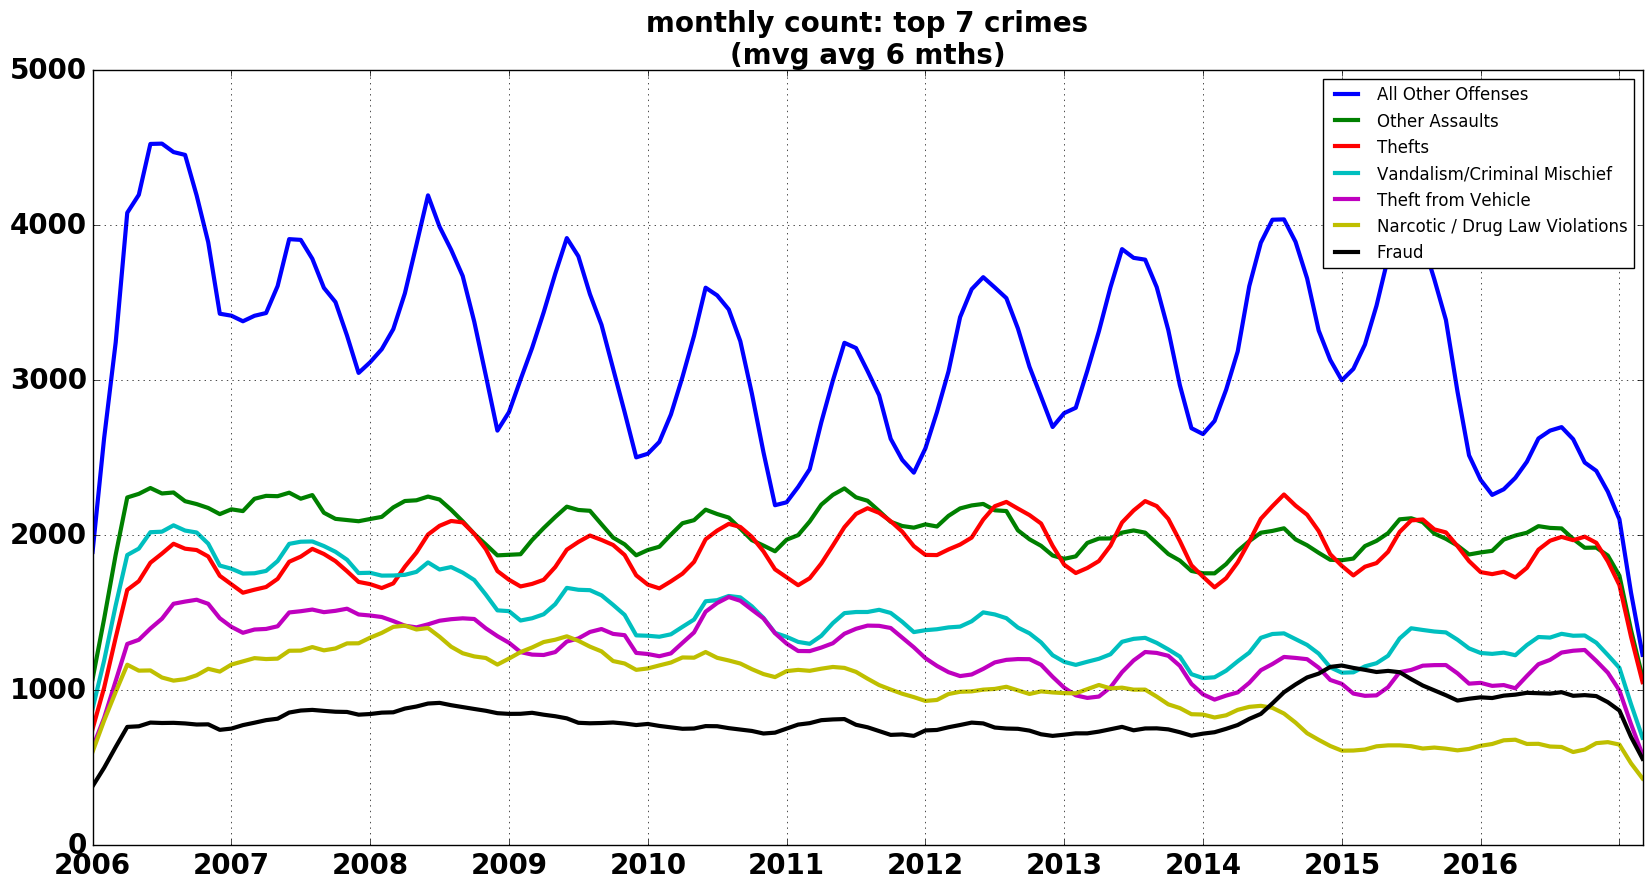

In [6]:
size=7 # for obtaining the count of crimes that related to one particular cause

causes = DF.groupby('CAUSE')['COUNT'].count().sort_values(ascending=False)[:size].index#using the group by function

plt.figure(figsize=(20,10))

handle=[]

for i in causes:
    
    dummy_df = DF[DF['CAUSE']==i] 
    
    dummy_by_date = dummy_df.groupby('MTH_COUNT')['COUNT'].sum().reset_index()
    
#grouping by mth_count and finding the sum of final count
    plt.plot_date(dummy_by_date['MTH_COUNT'],movingaverage(dummy_by_date['COUNT'],6), '-', linewidth=3)
    
    handle=handle+['%s' %i]
    
plt.legend(handle)


xmin=min(dummy_df['MTH_COUNT']) # defining the max and min 
xmax=max(dummy_df['MTH_COUNT'])

plt.xticks(np.arange(xmin,xmax+1,12), np.arange((interval), dtype=int)+2006, **text_opts)

plt.yticks(**text_opts)
plt.grid() # top n crimes with average of 6mnths count in to consideration.
plt.title('monthly count: top %d crimes\n(mvg avg 6 mths)' %size, **text_opts)

From the above findings, lets deep drill how these causes resulting in crimes trending in Police departmental districts.

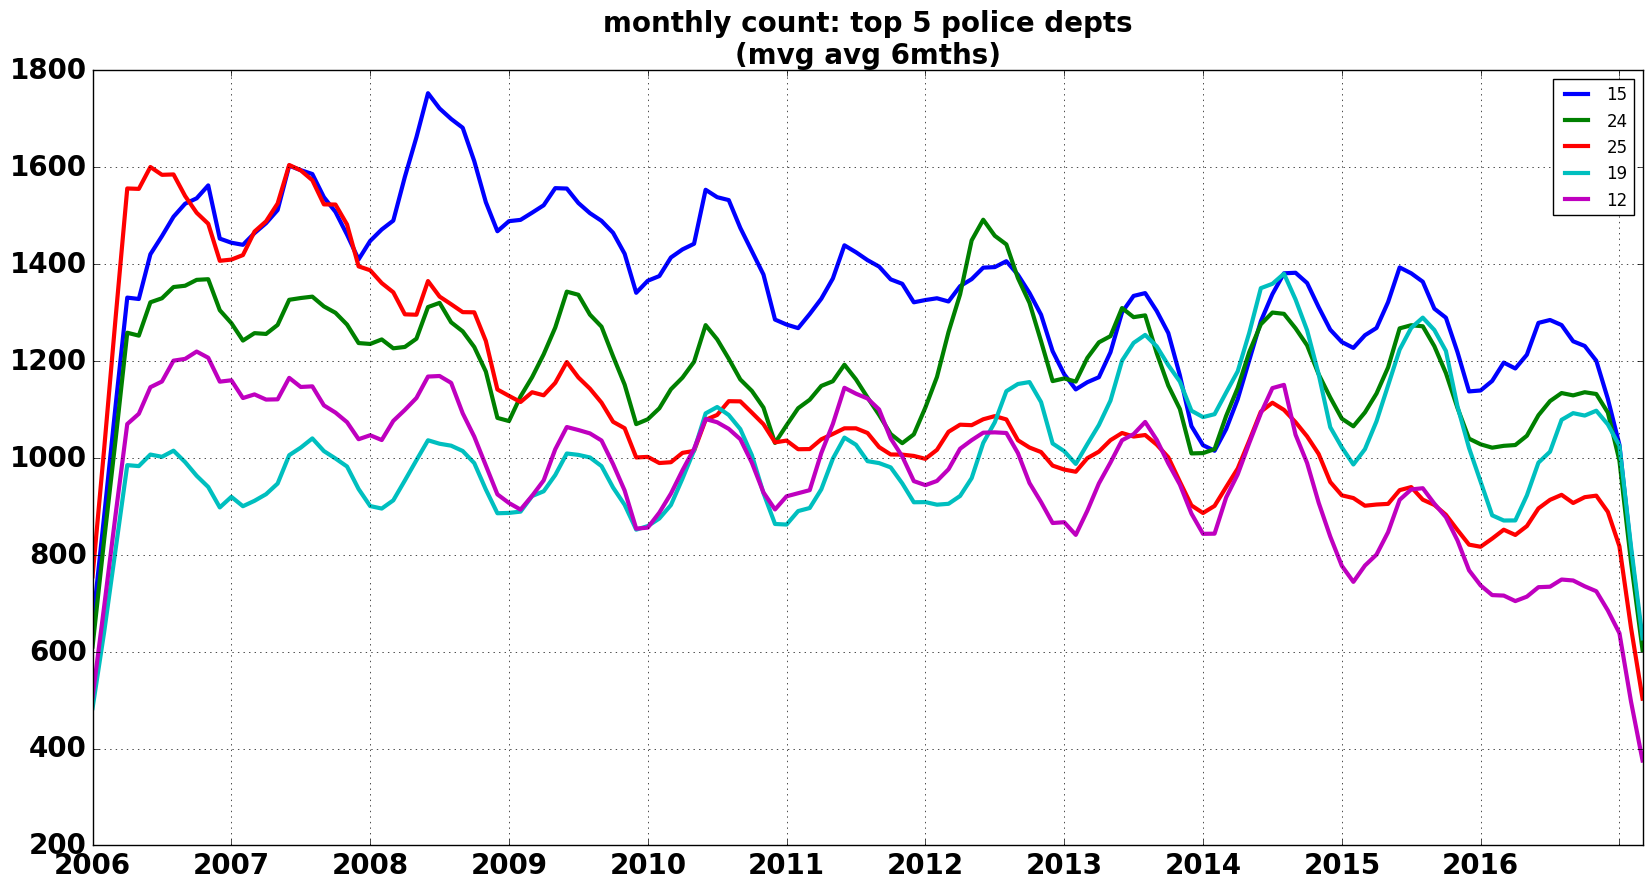

In [7]:
size=5 # grouping by district and sort the values

pds = DF.groupby('DISTRICT')['COUNT'].count().sort_values(ascending=False)[:size].index

plt.figure(figsize=(20,10))

handle=[]

for i in pds:
    
    dummy_df = DF[DF['DISTRICT']==i] 
    
    dummy_by_date = dummy_df.groupby('MTH_COUNT')['COUNT'].sum().reset_index()
    
    #grouping by mth_count and finding the sum of final count
    
    
    plt.plot_date(dummy_by_date['MTH_COUNT'],movingaverage(dummy_by_date['COUNT'],6), '-', linewidth=3)
    
    handle=handle+['%s' %i]
    
plt.legend(handle) # for dealing with top n police department regions for finding the trends of crime rate here

xmin=min(dummy_df['MTH_COUNT'])
xmax=max(dummy_df['MTH_COUNT'])

plt.xticks(np.arange(xmin,xmax+1,12), np.arange((interval), dtype=int)+2006, **text_opts)

plt.yticks(**text_opts)
plt.grid()
plt.title('monthly count: top %d police depts\n(mvg avg 6mths)' %size, **text_opts)

Lets further deep drill the data by finding how these causes that are effecting the crimes are varying acrcoss different years

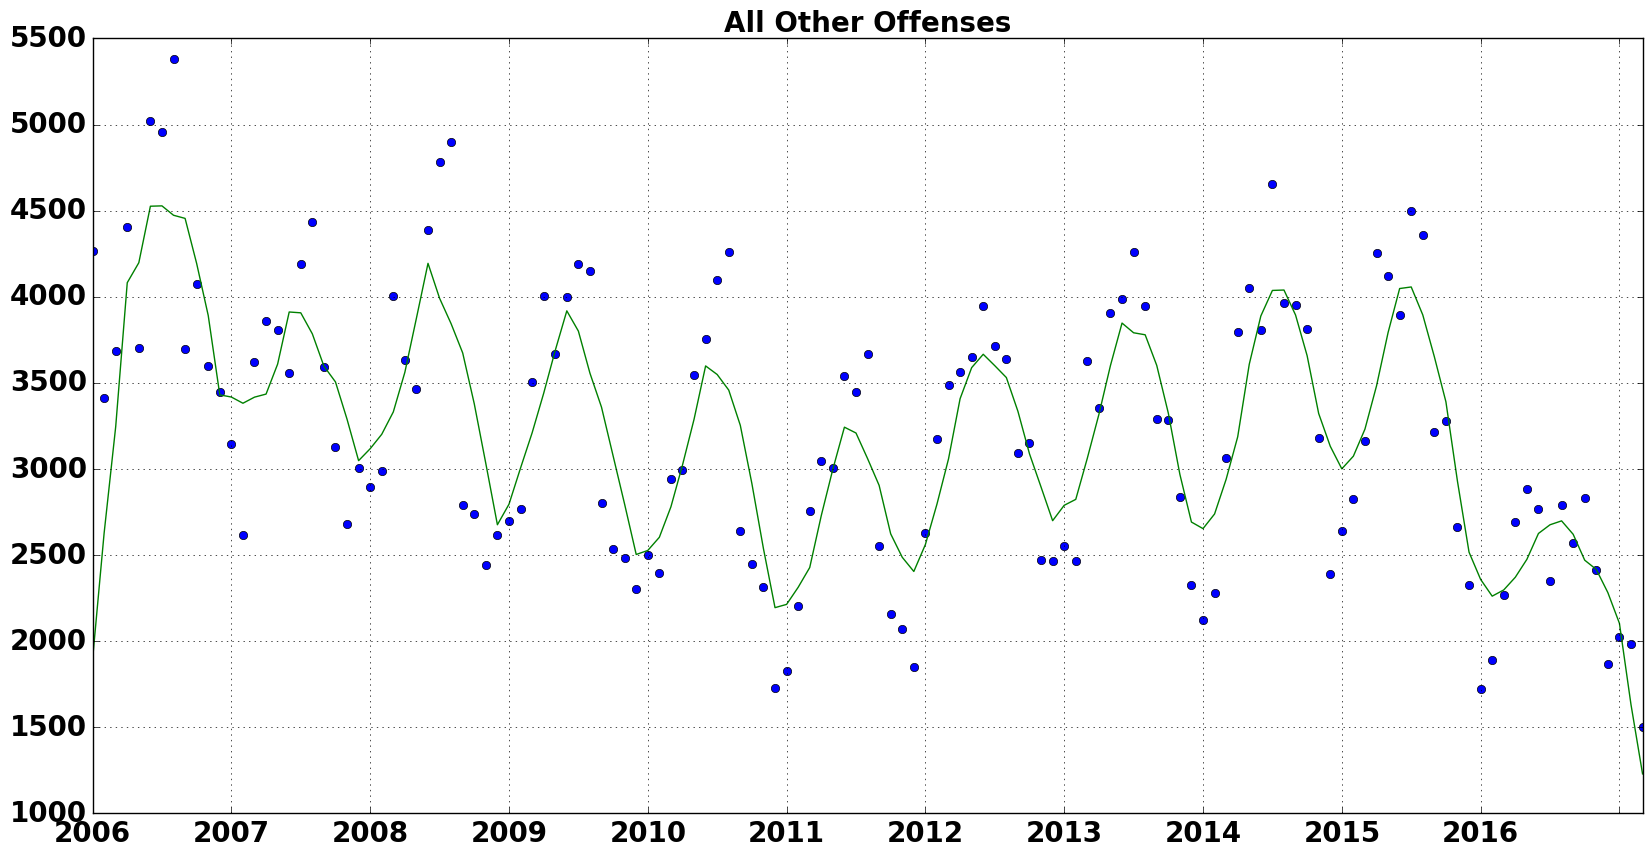

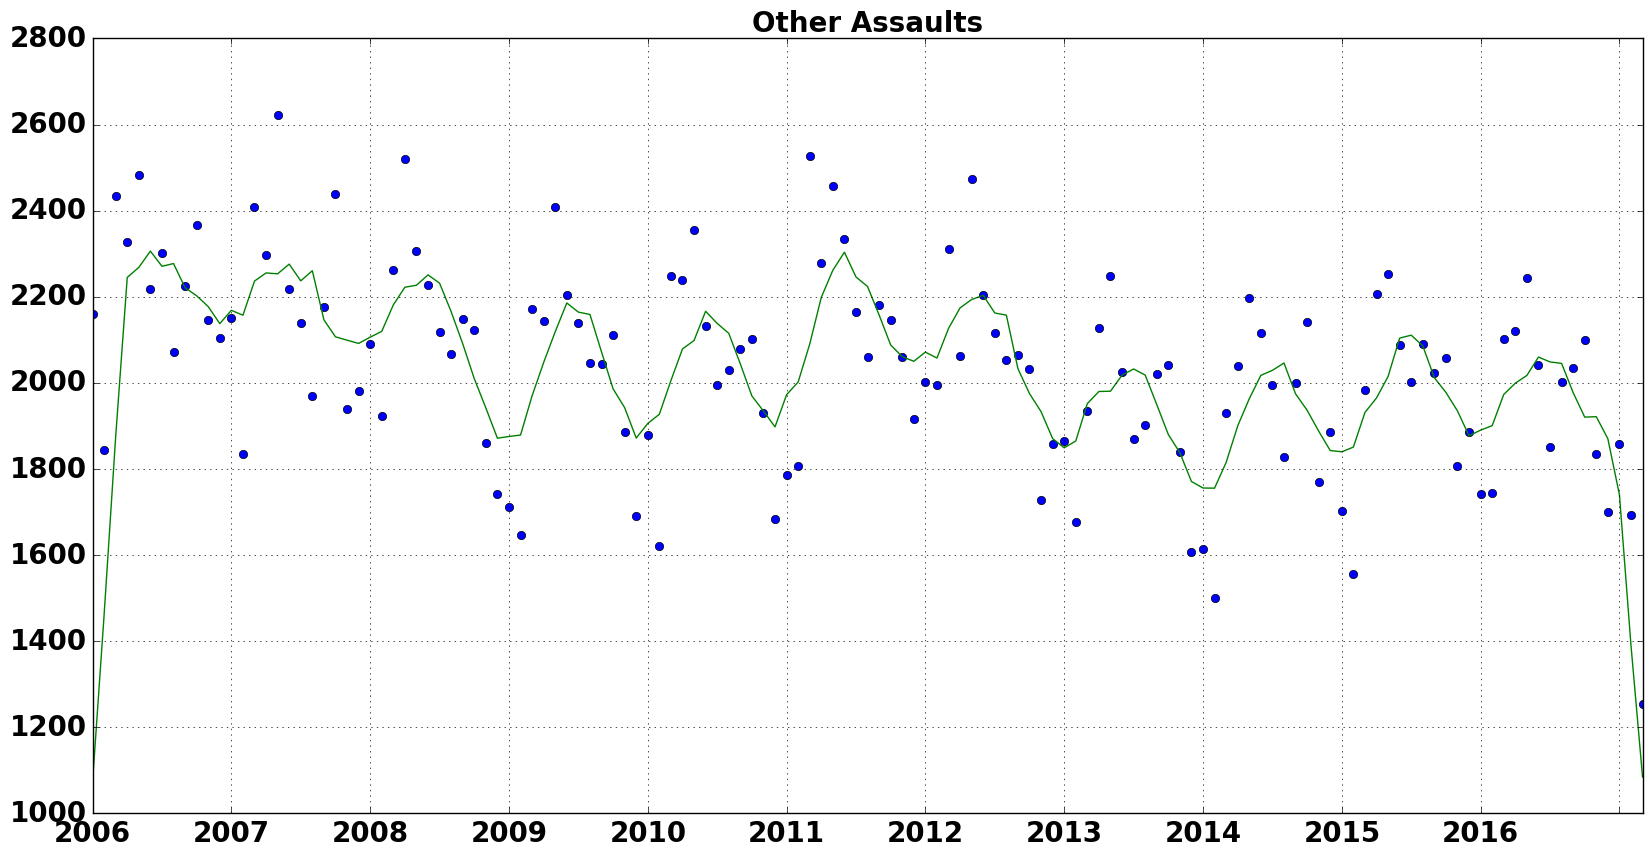

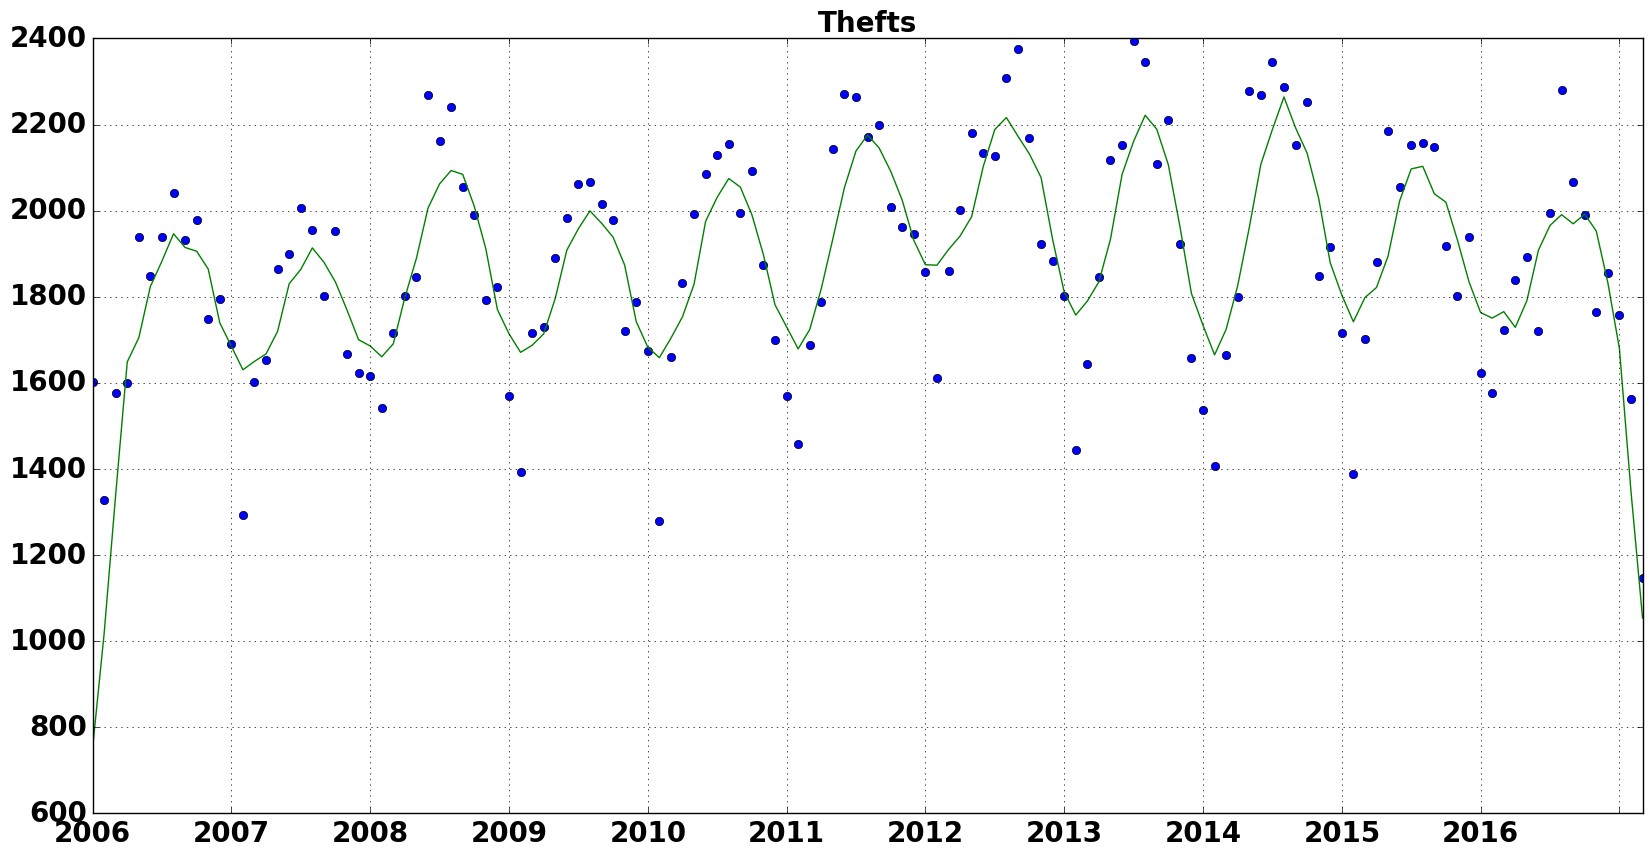

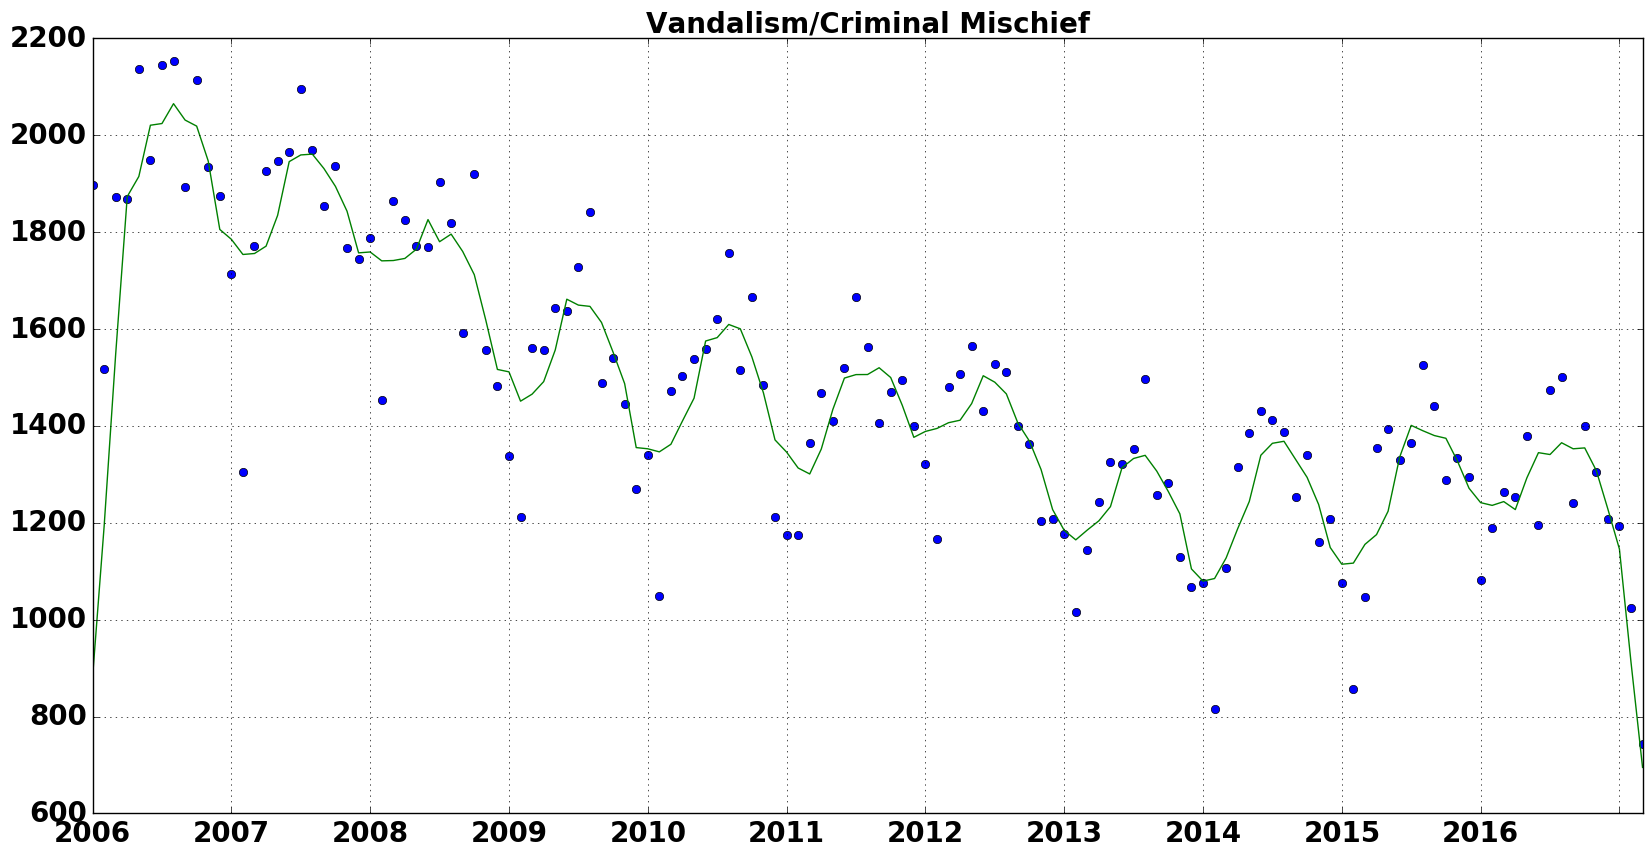

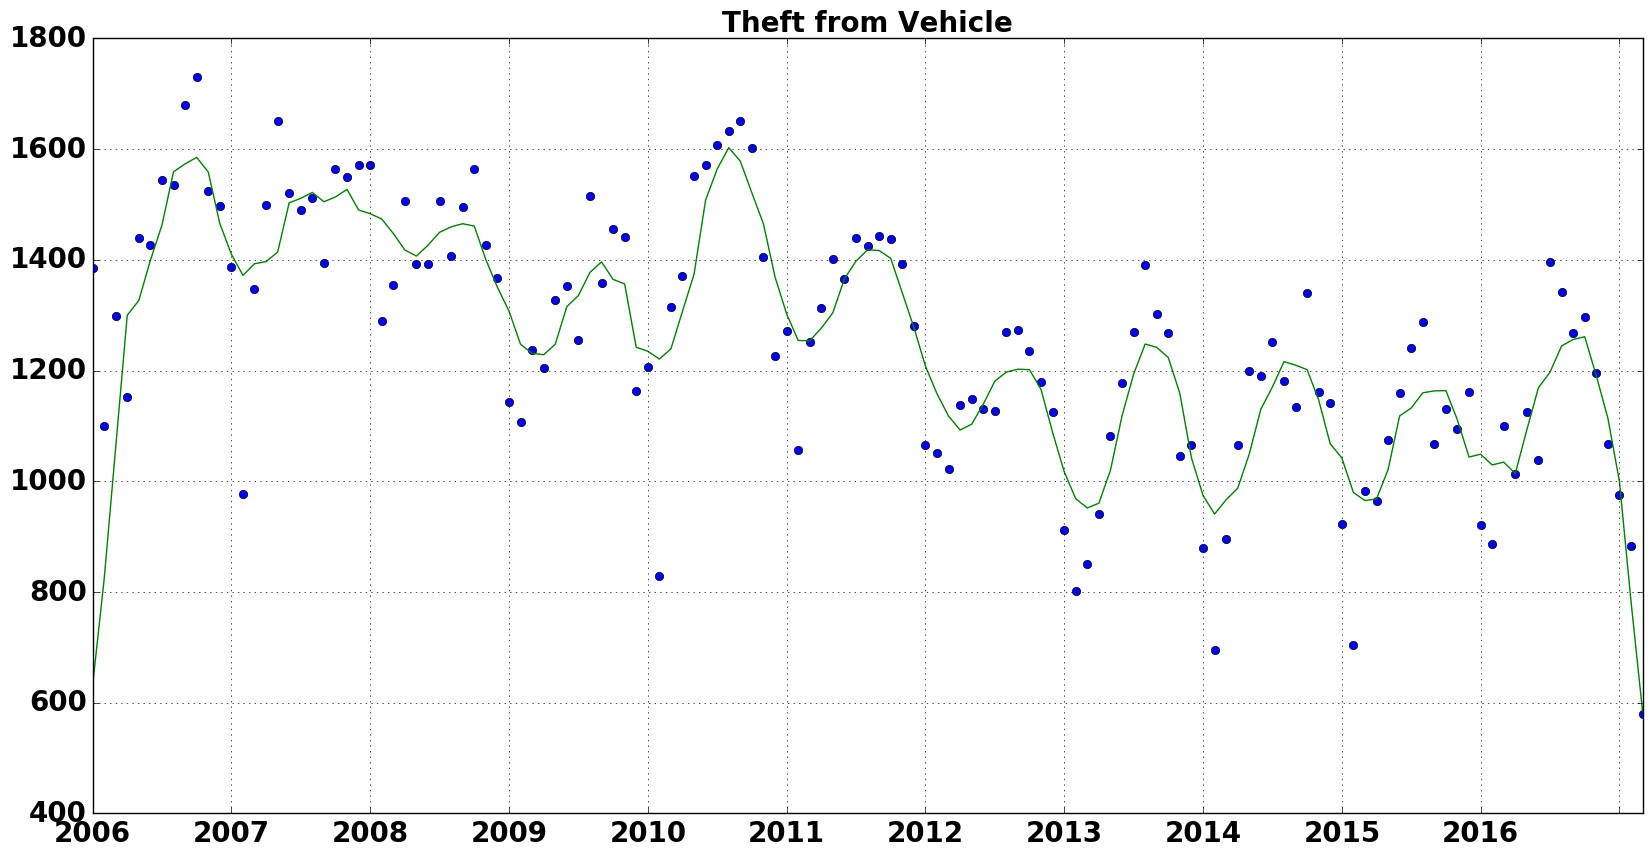

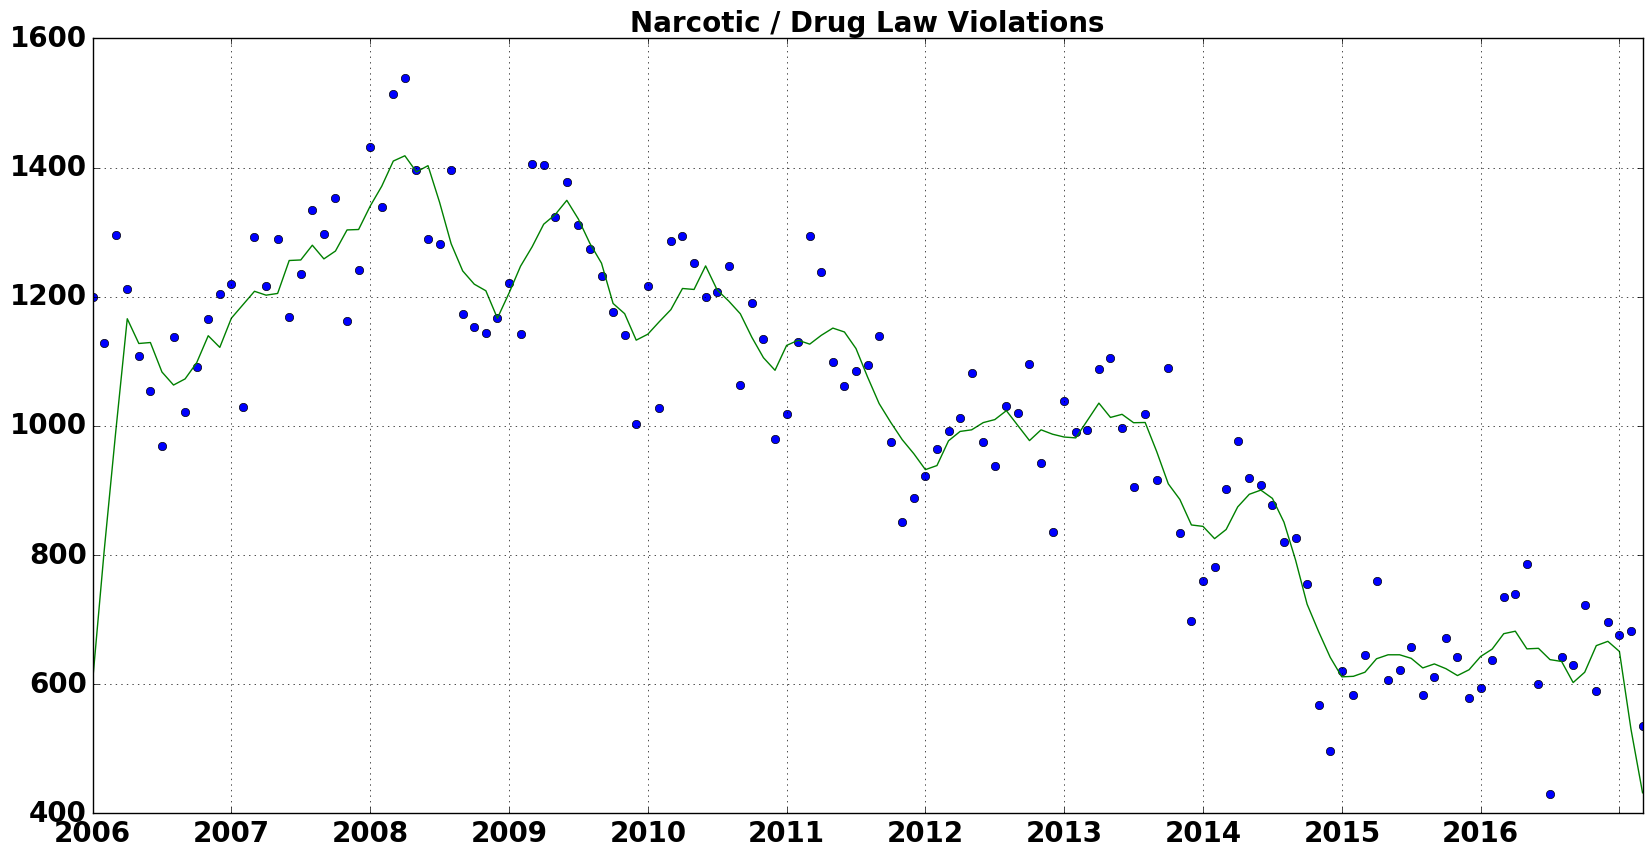

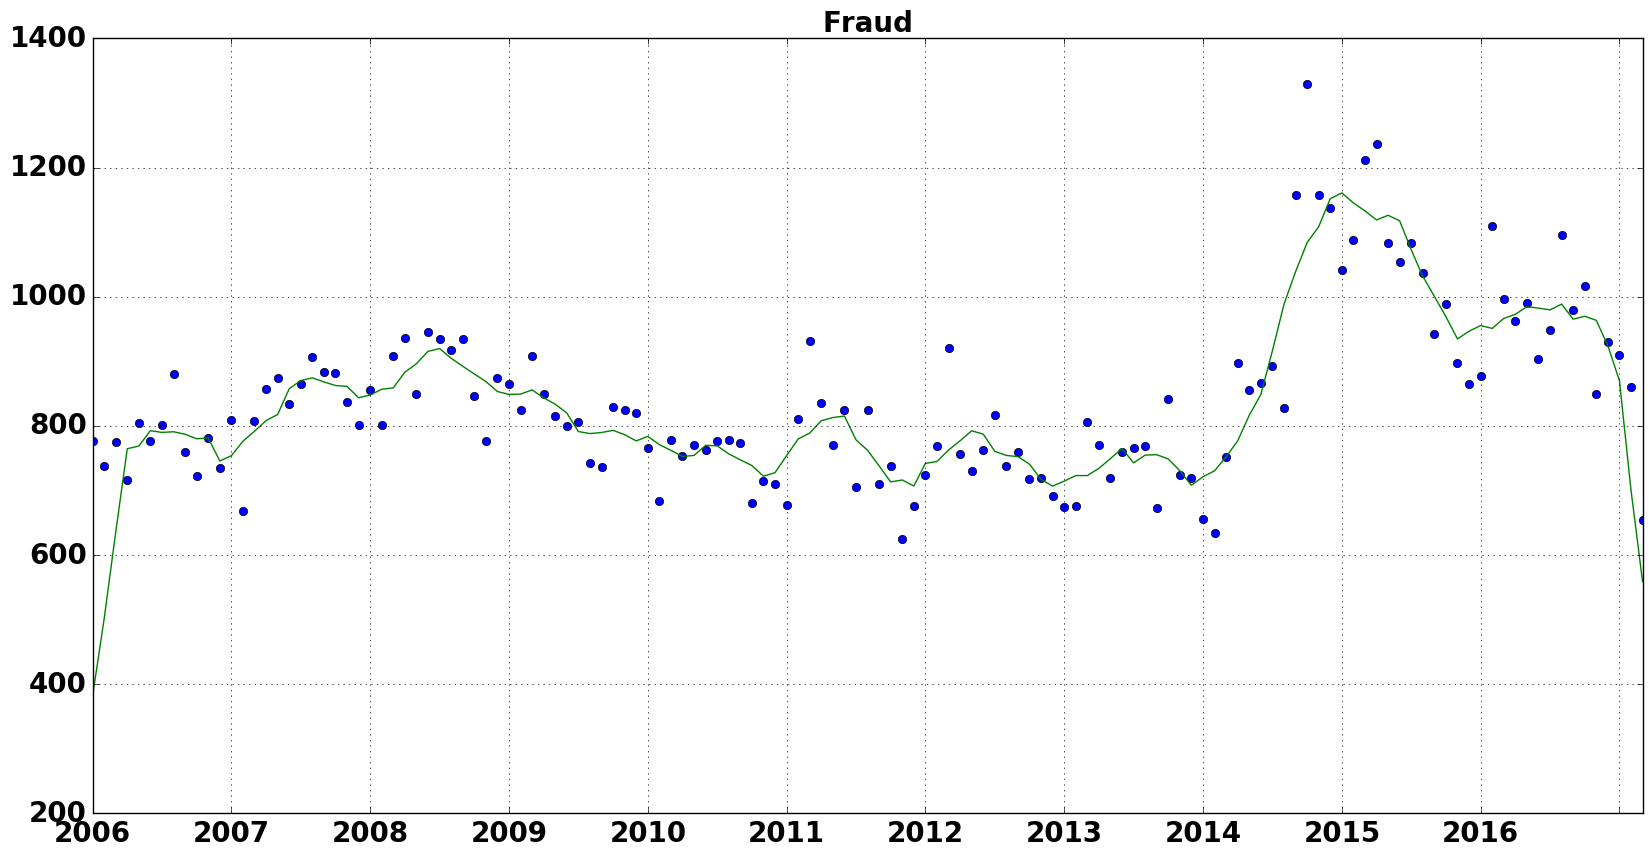

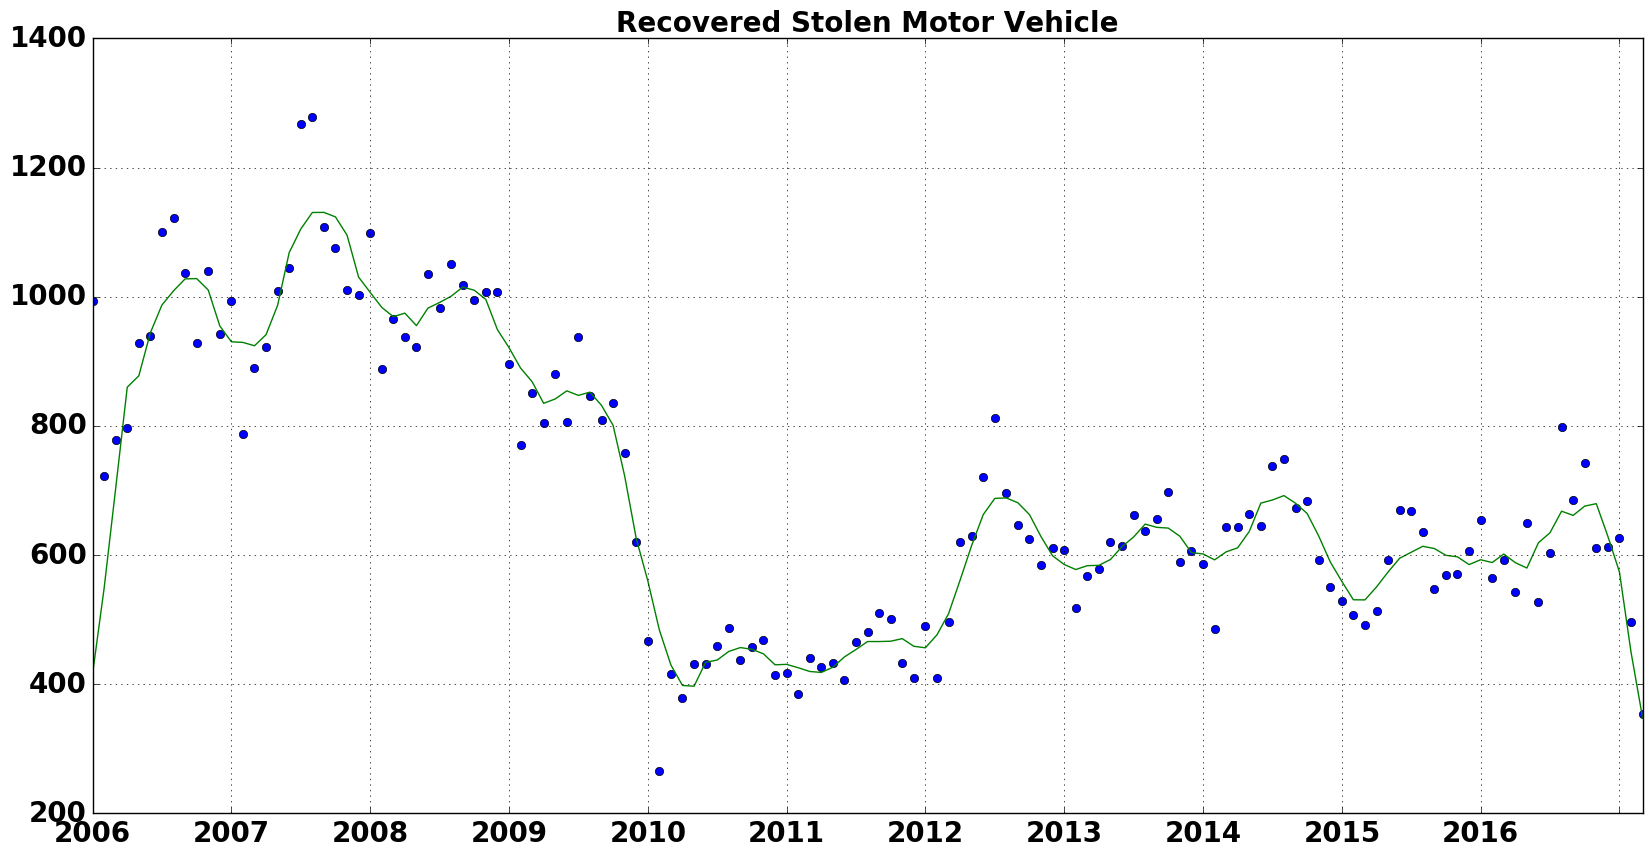

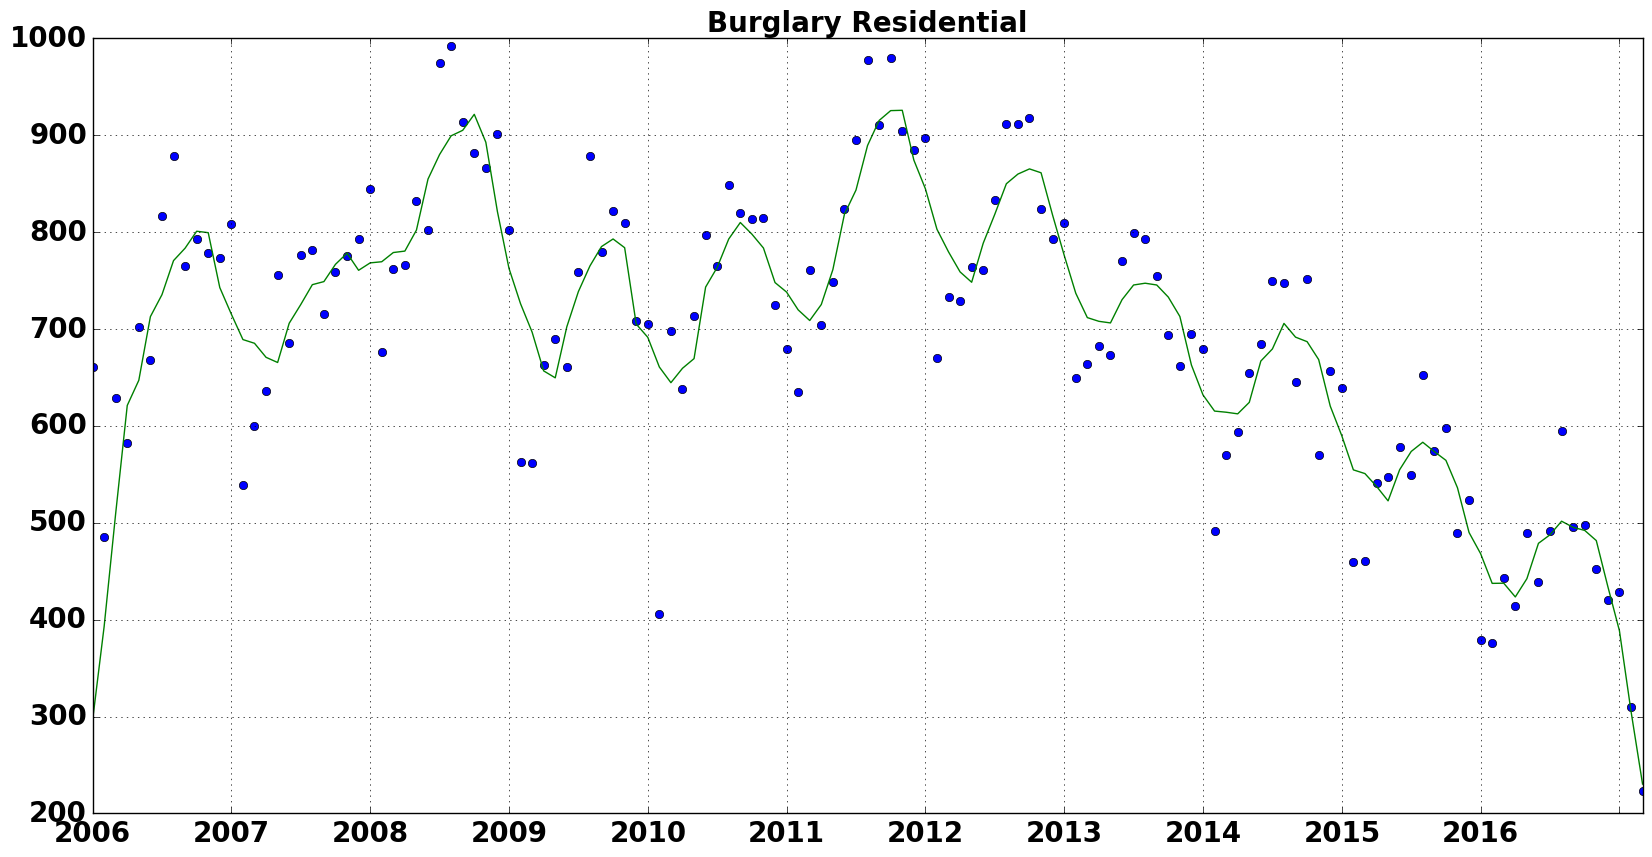

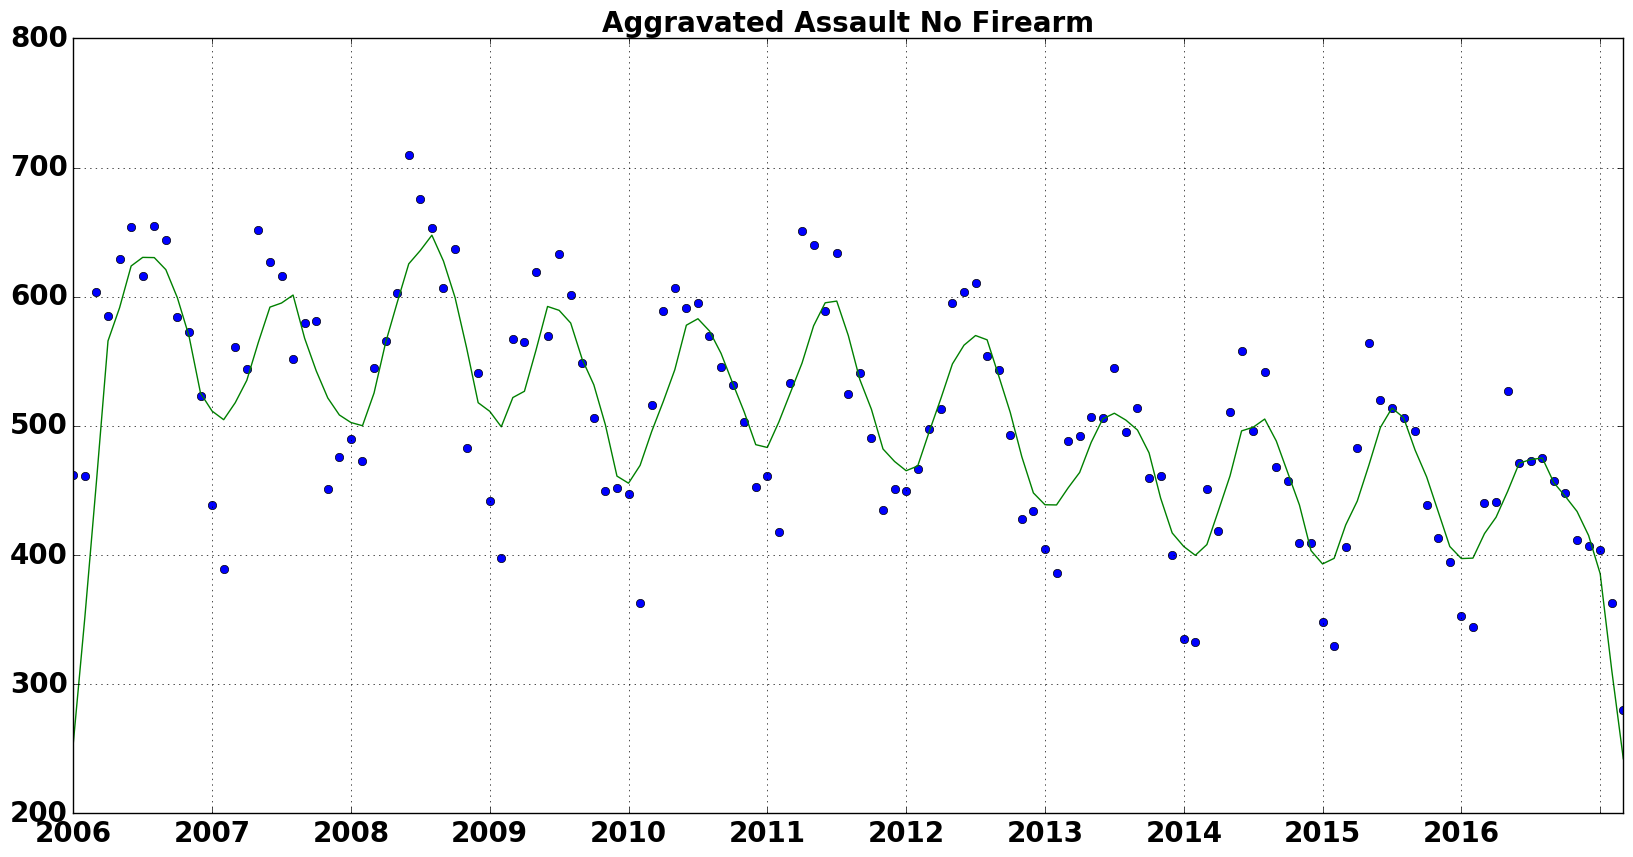

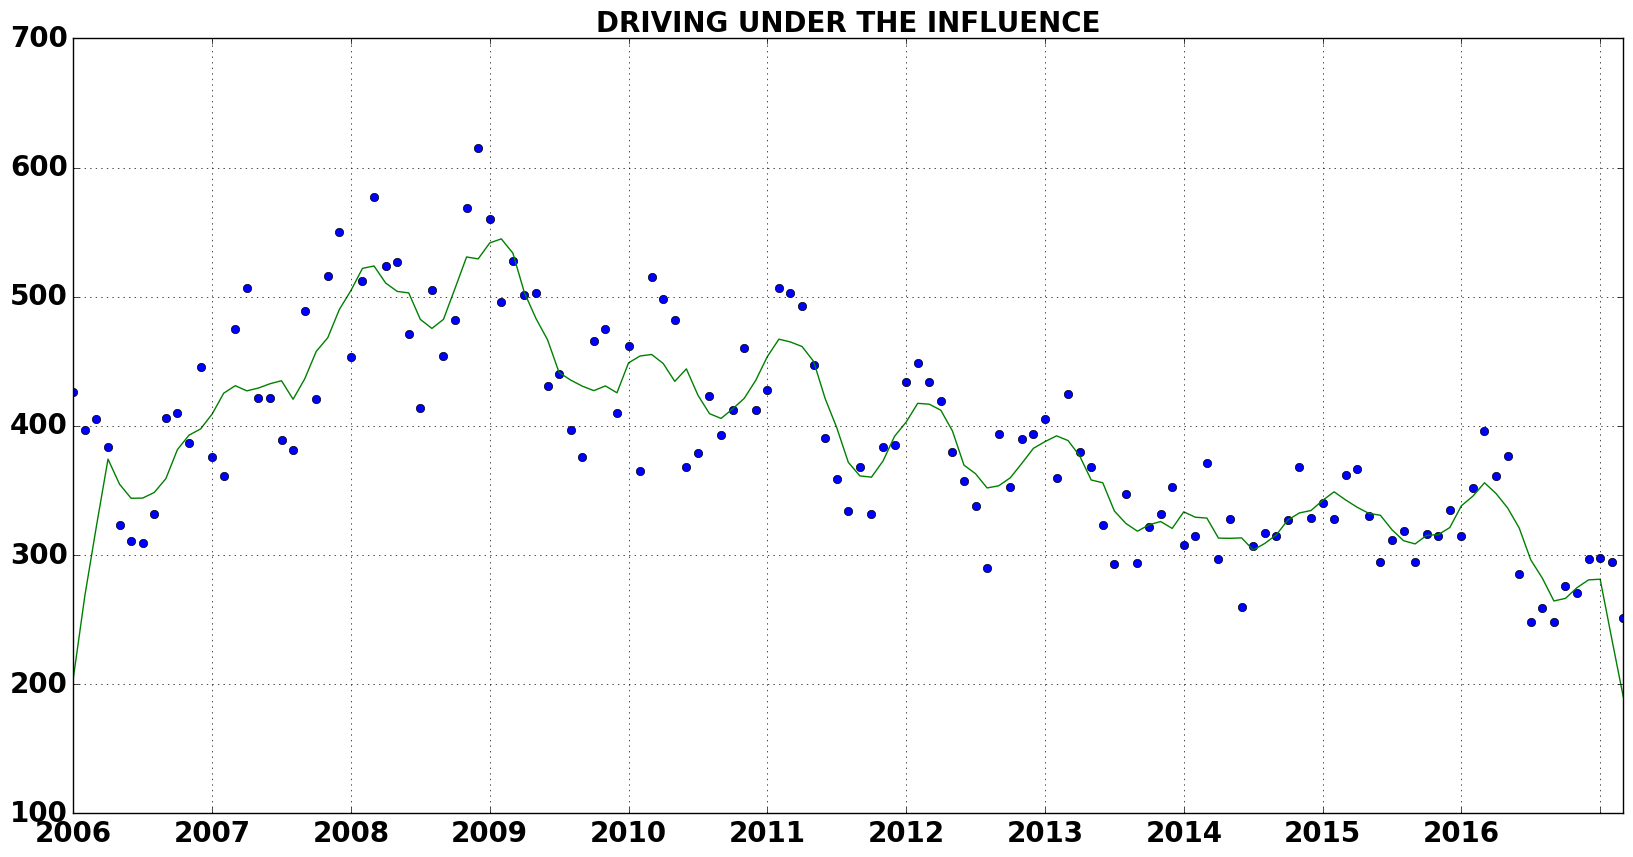

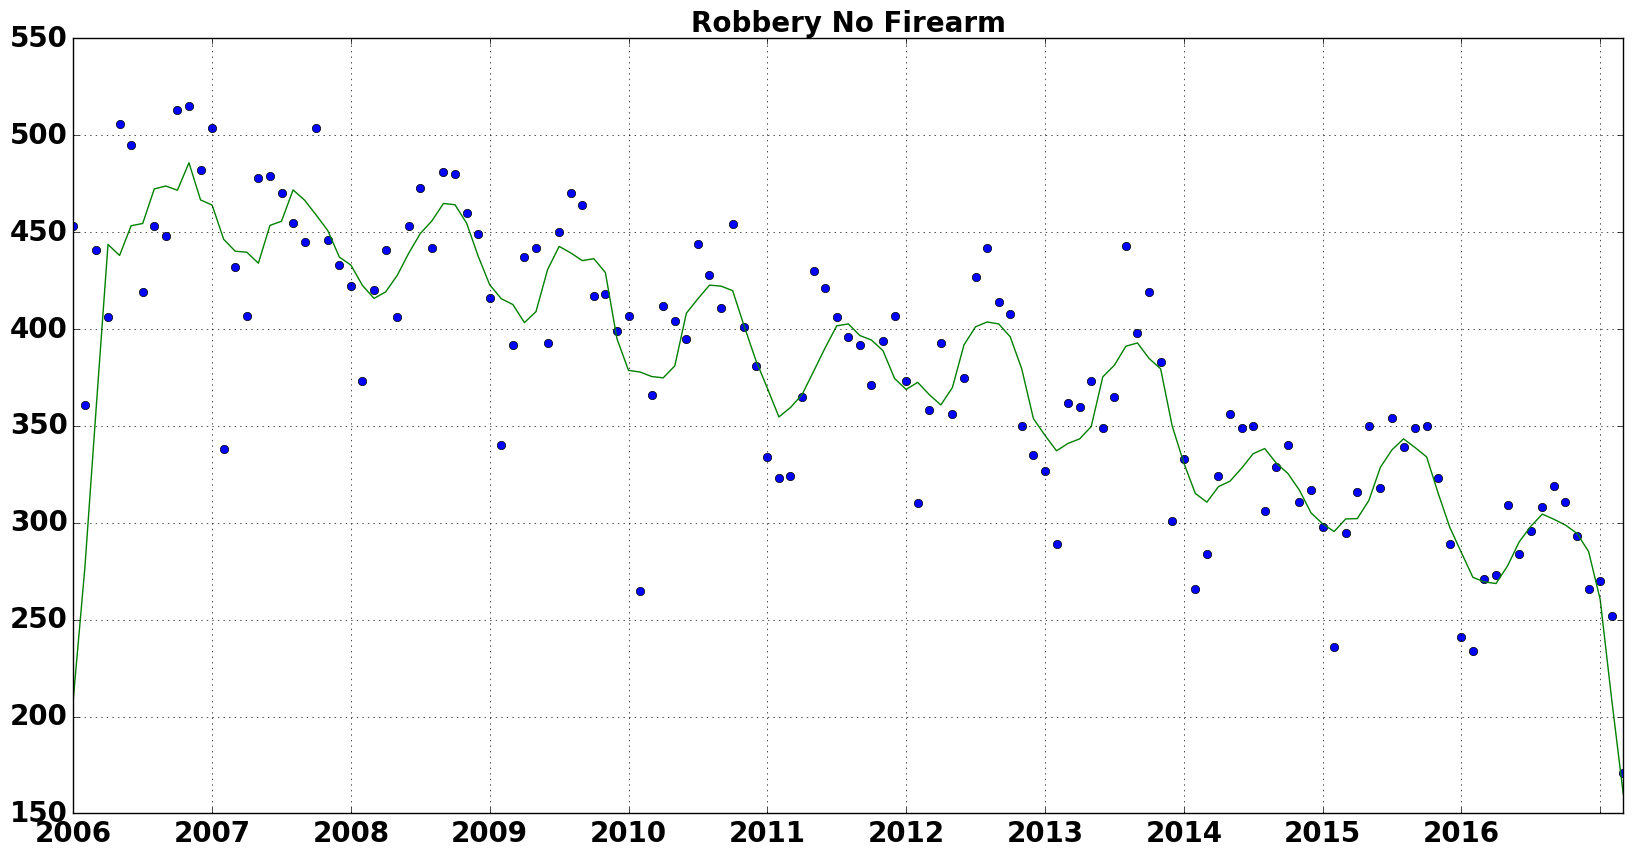

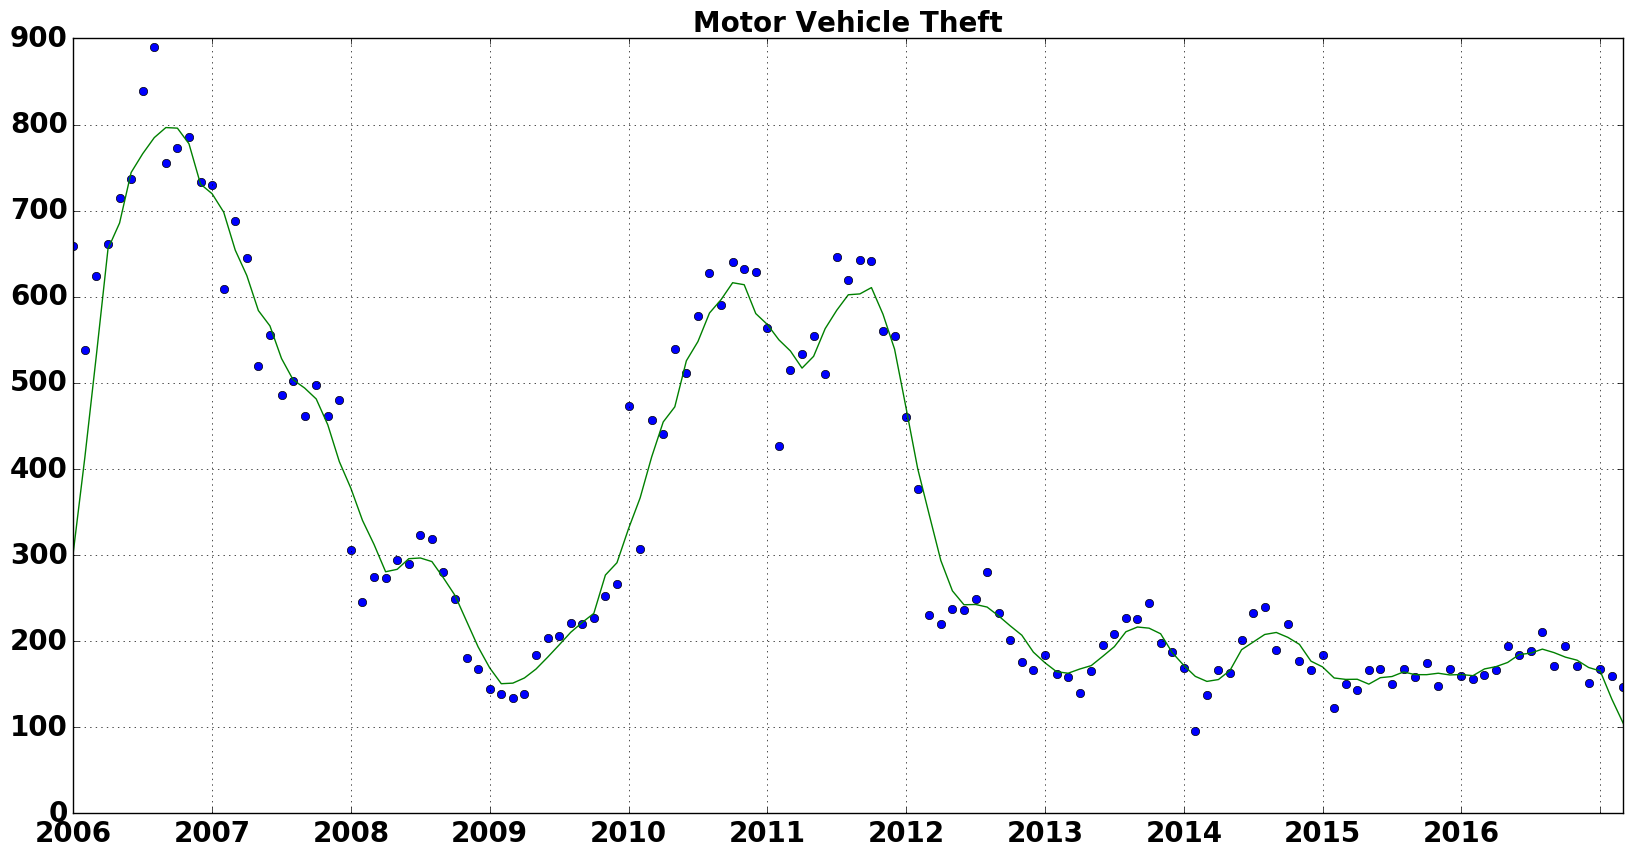

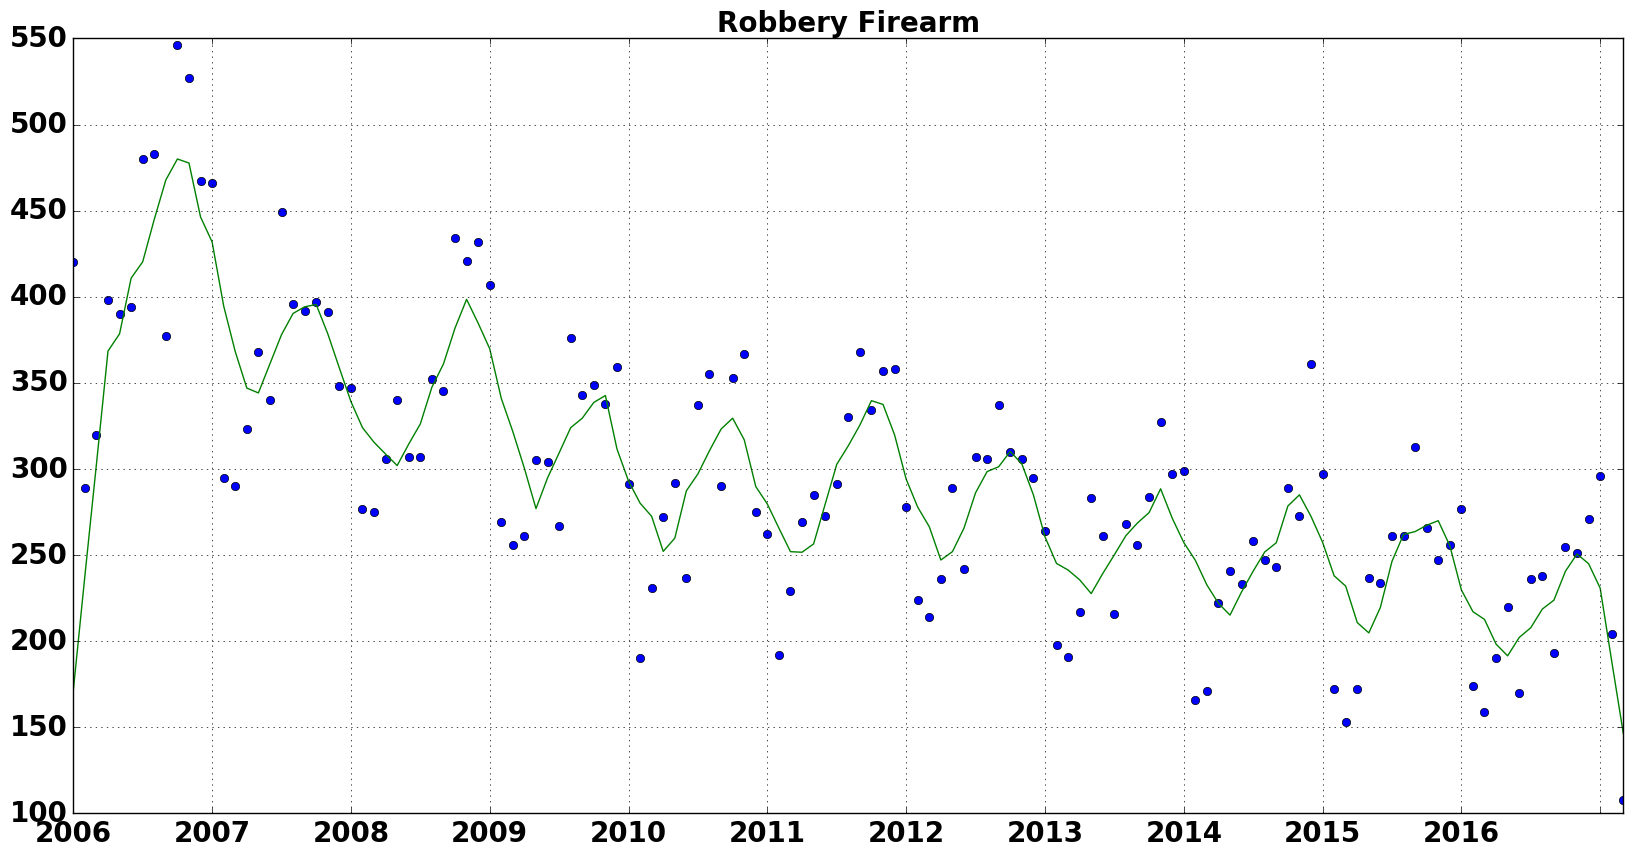

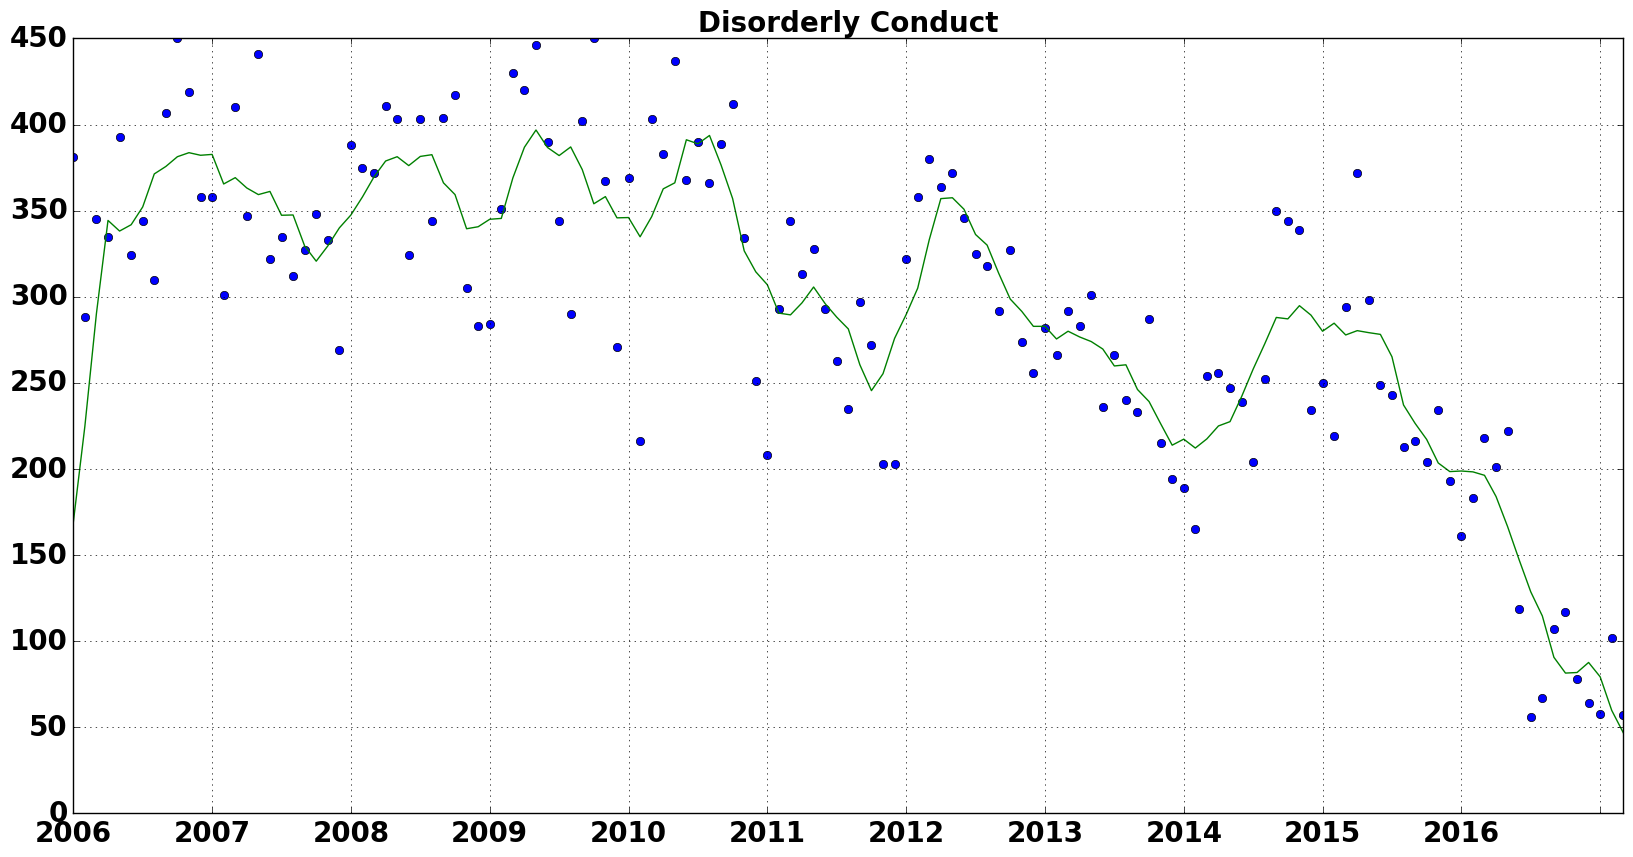

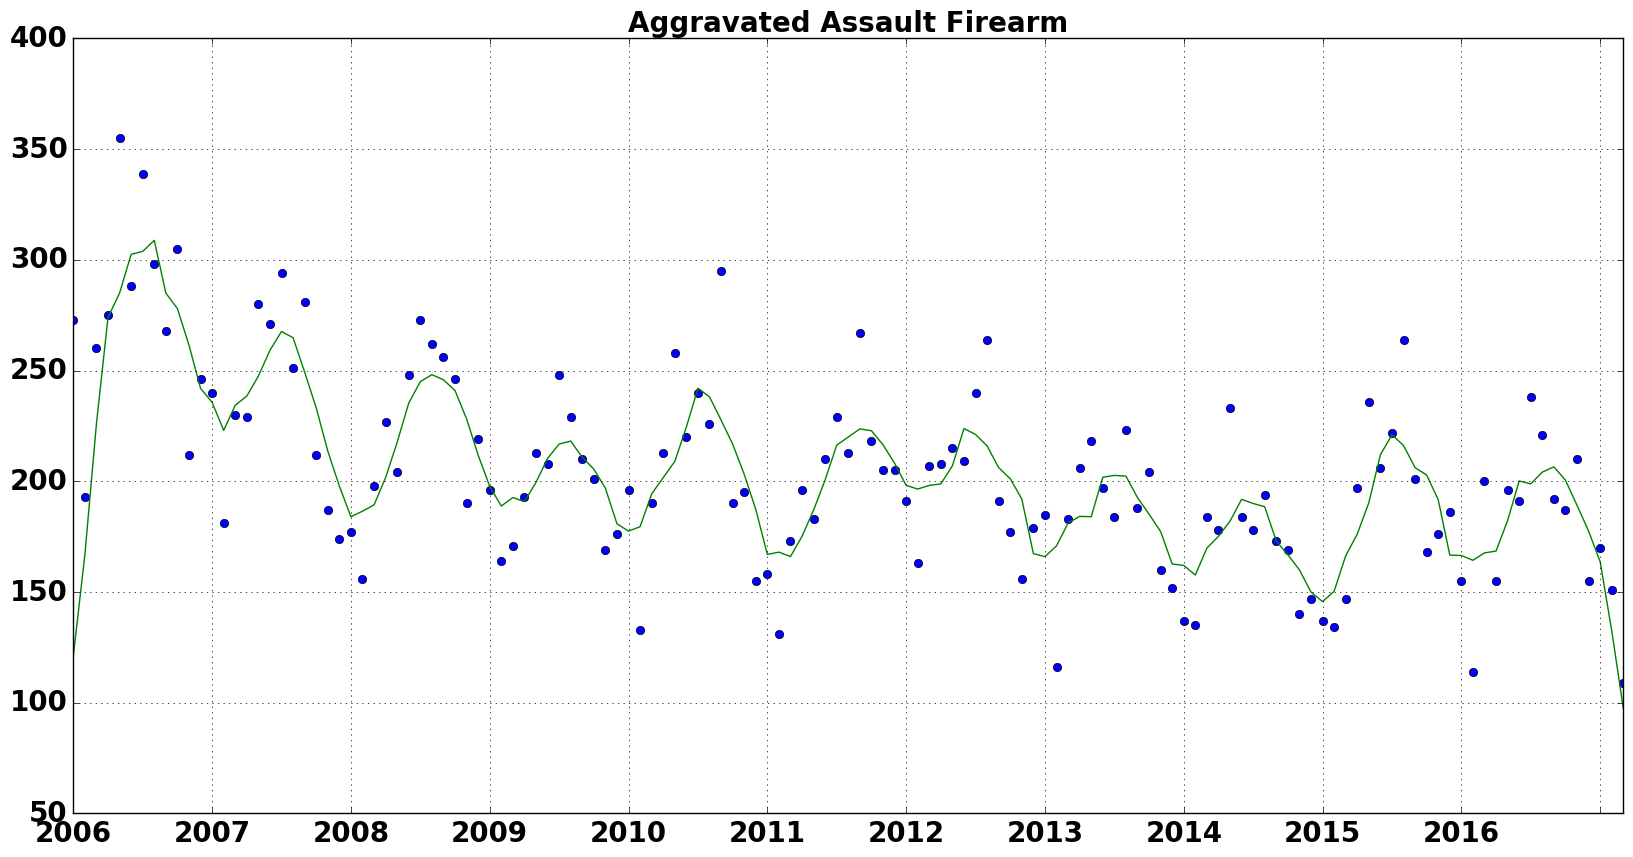

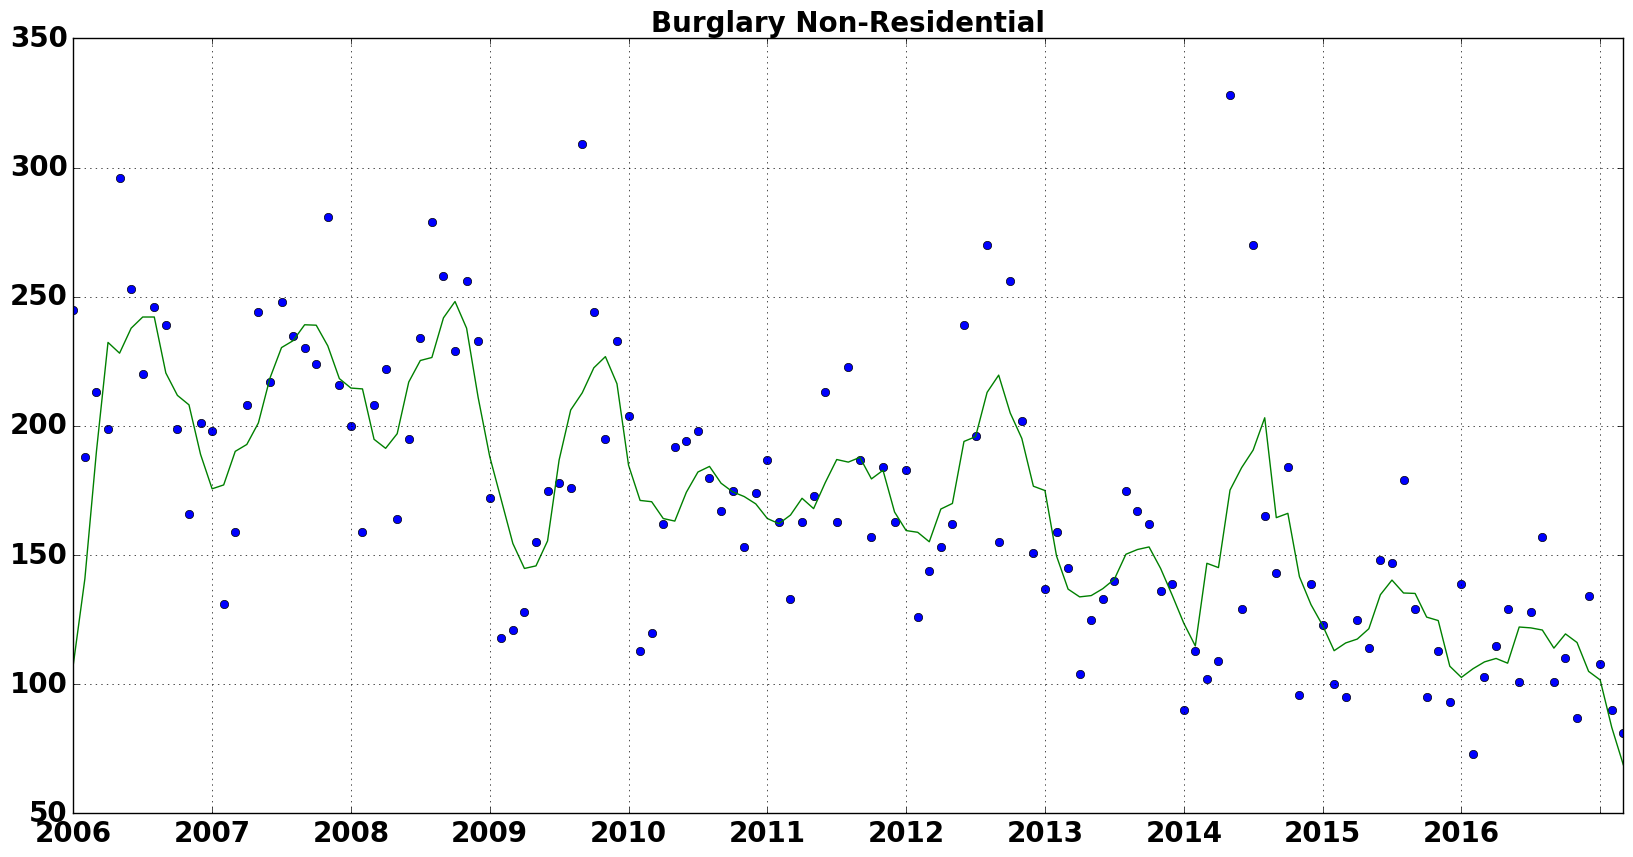

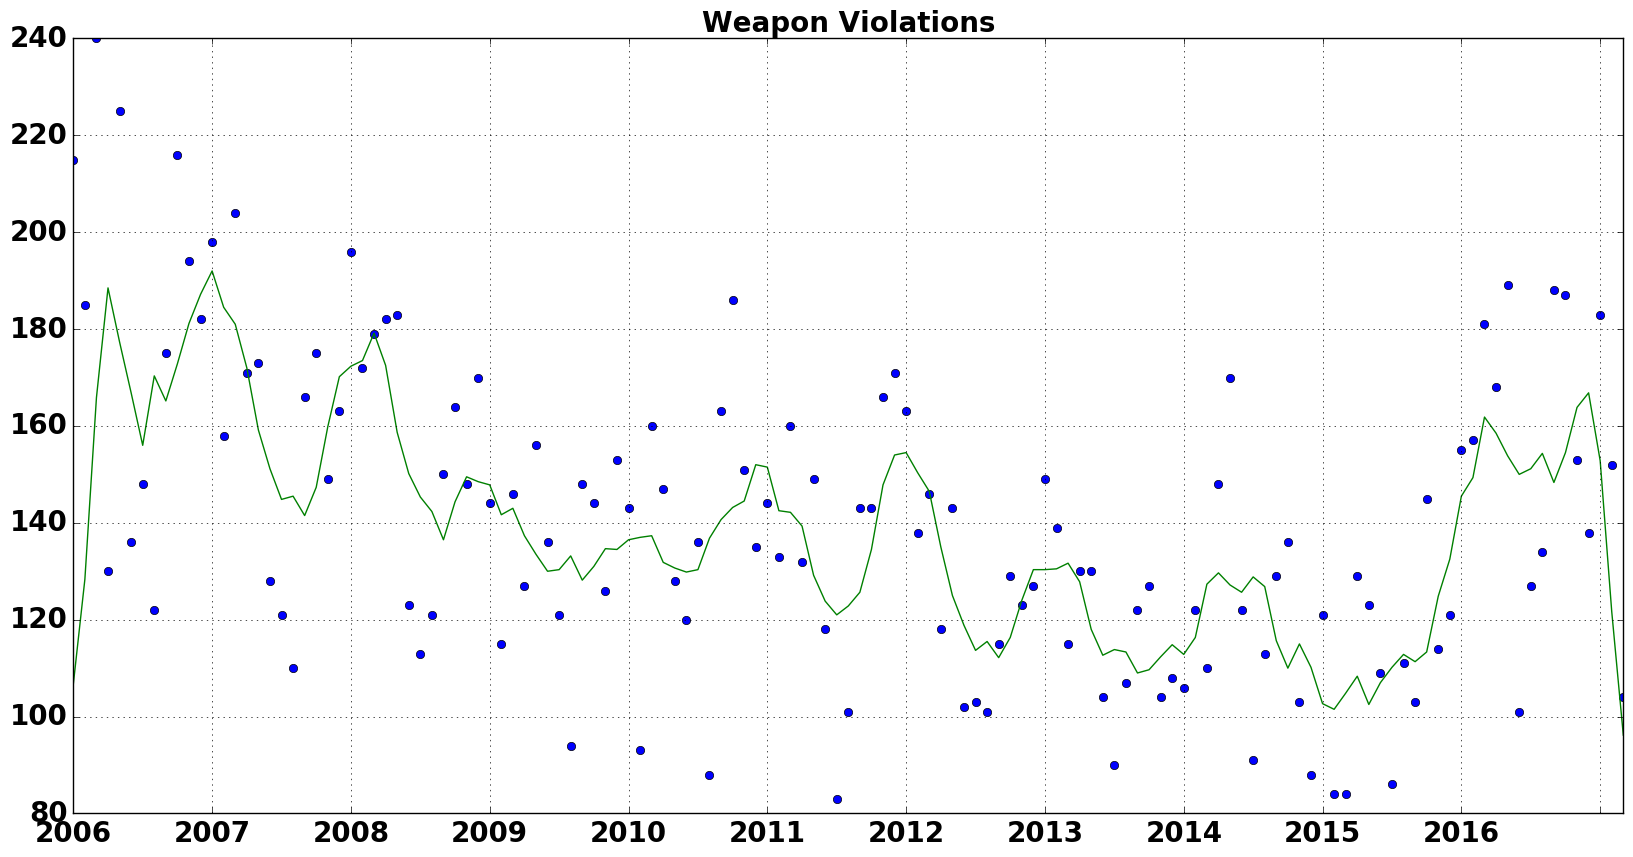

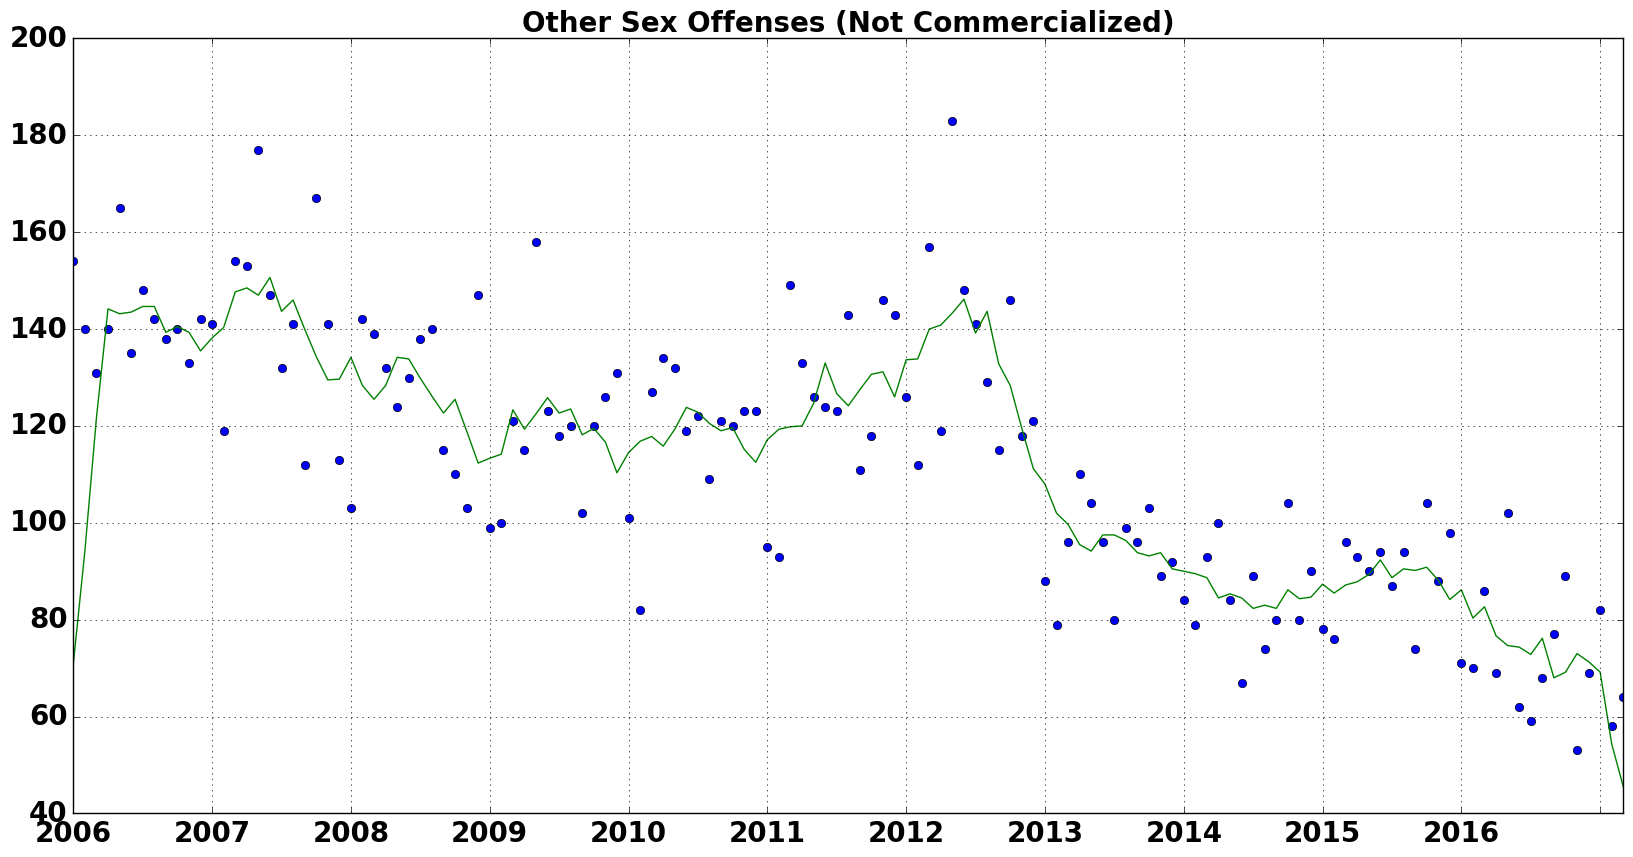

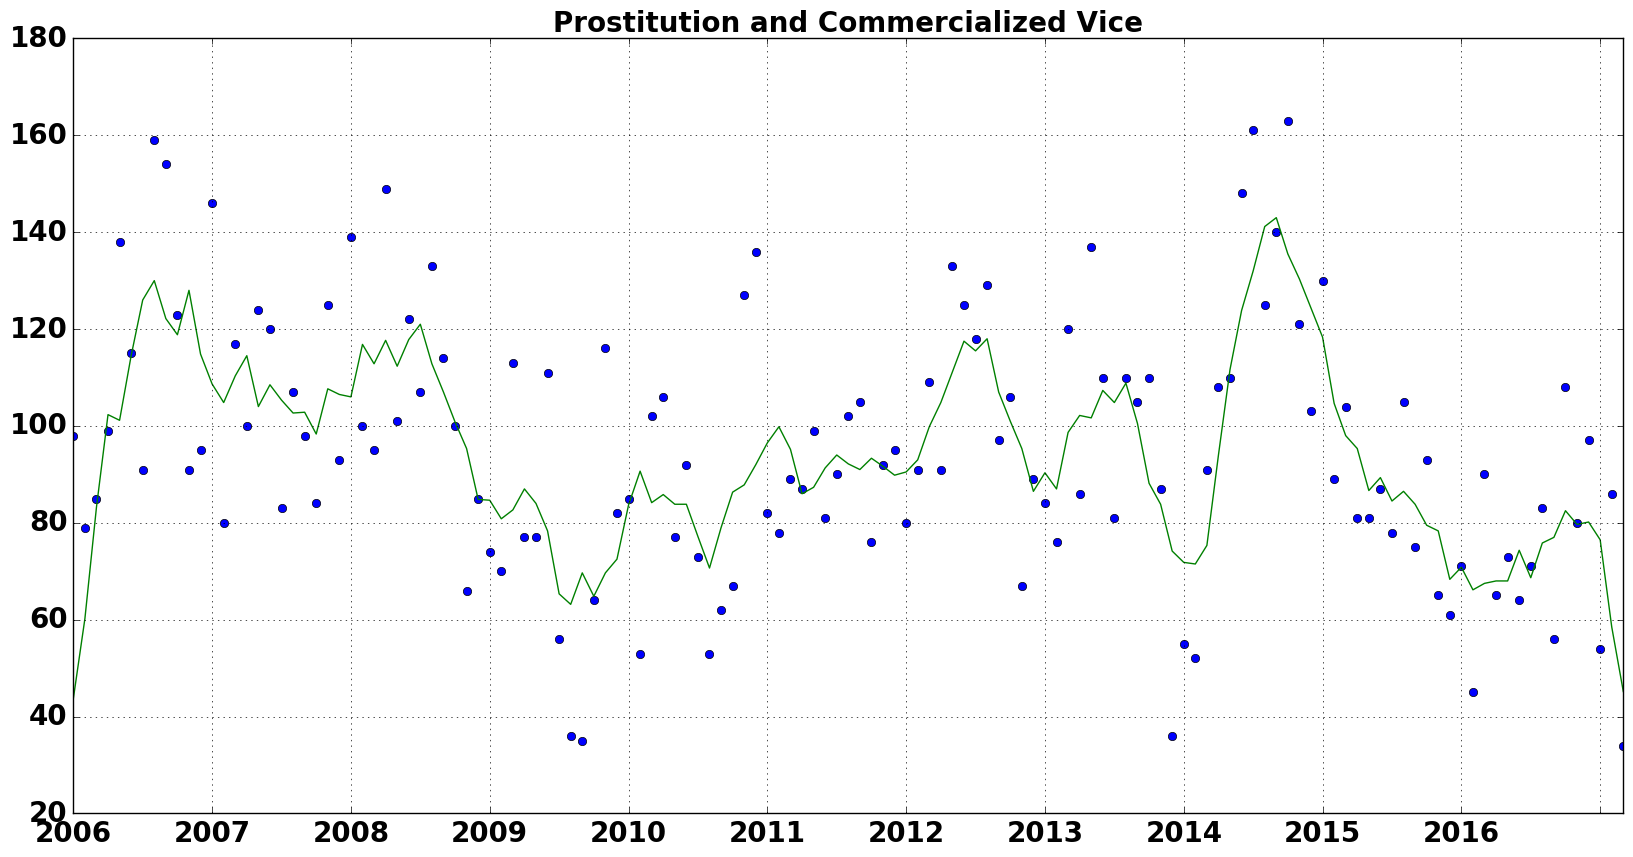

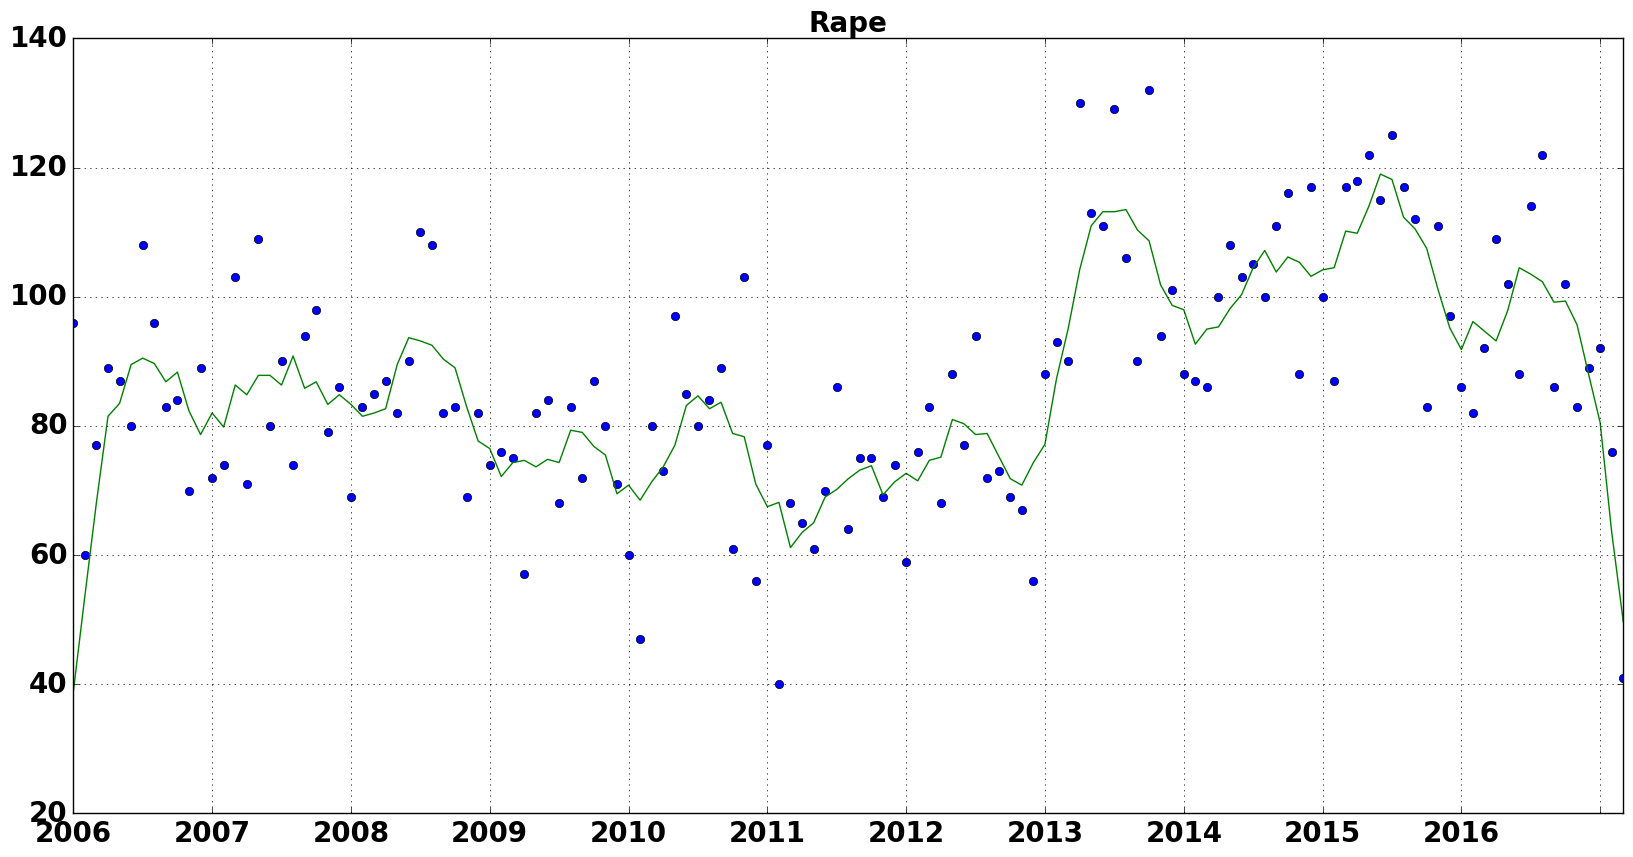

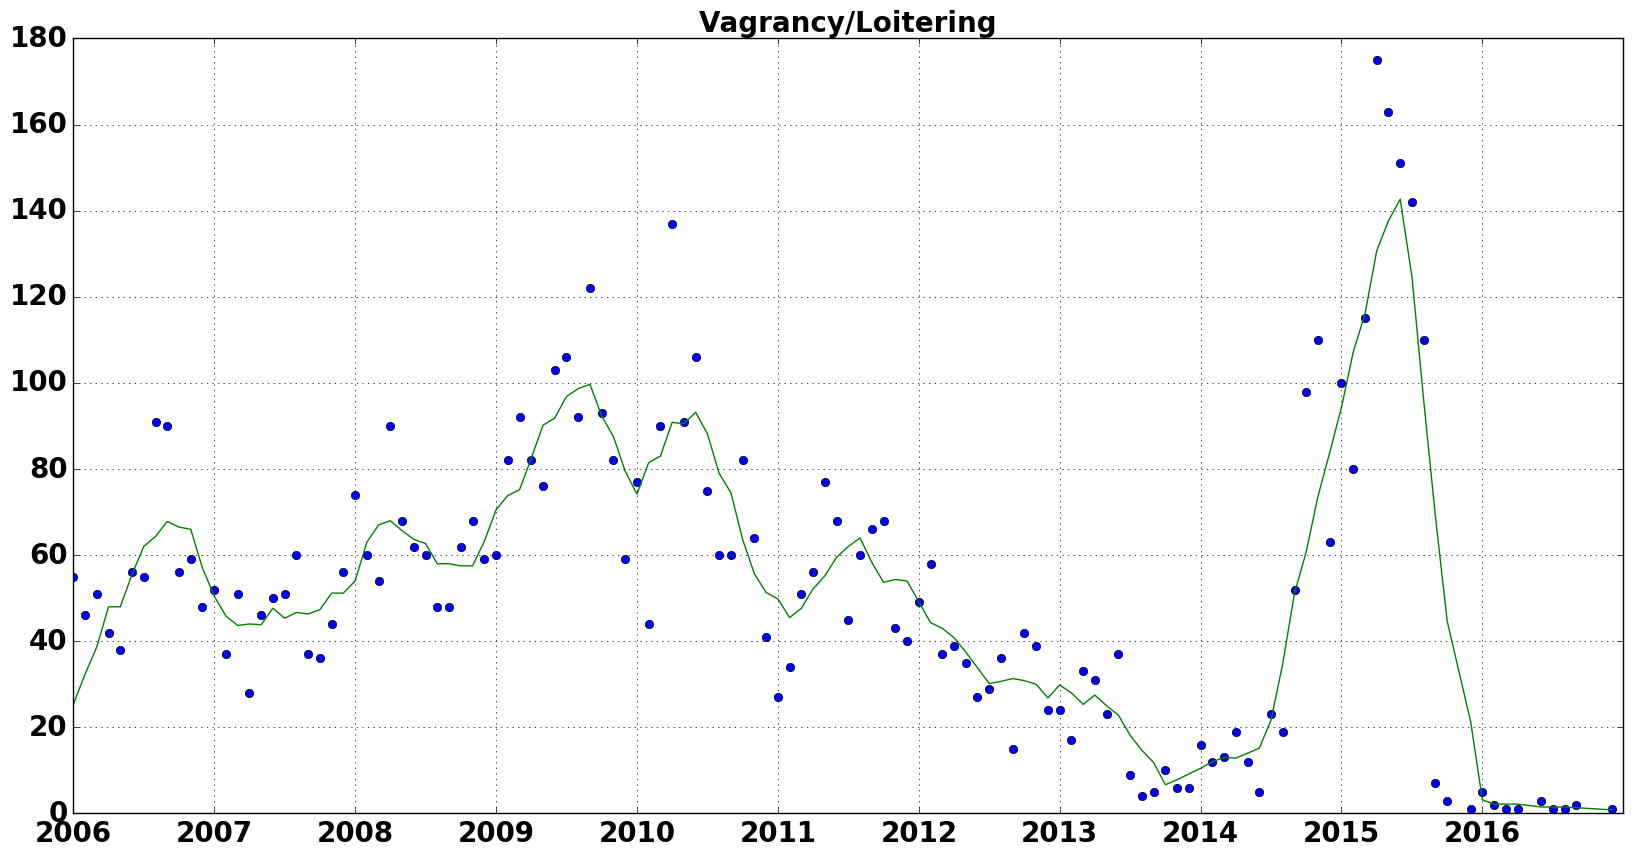

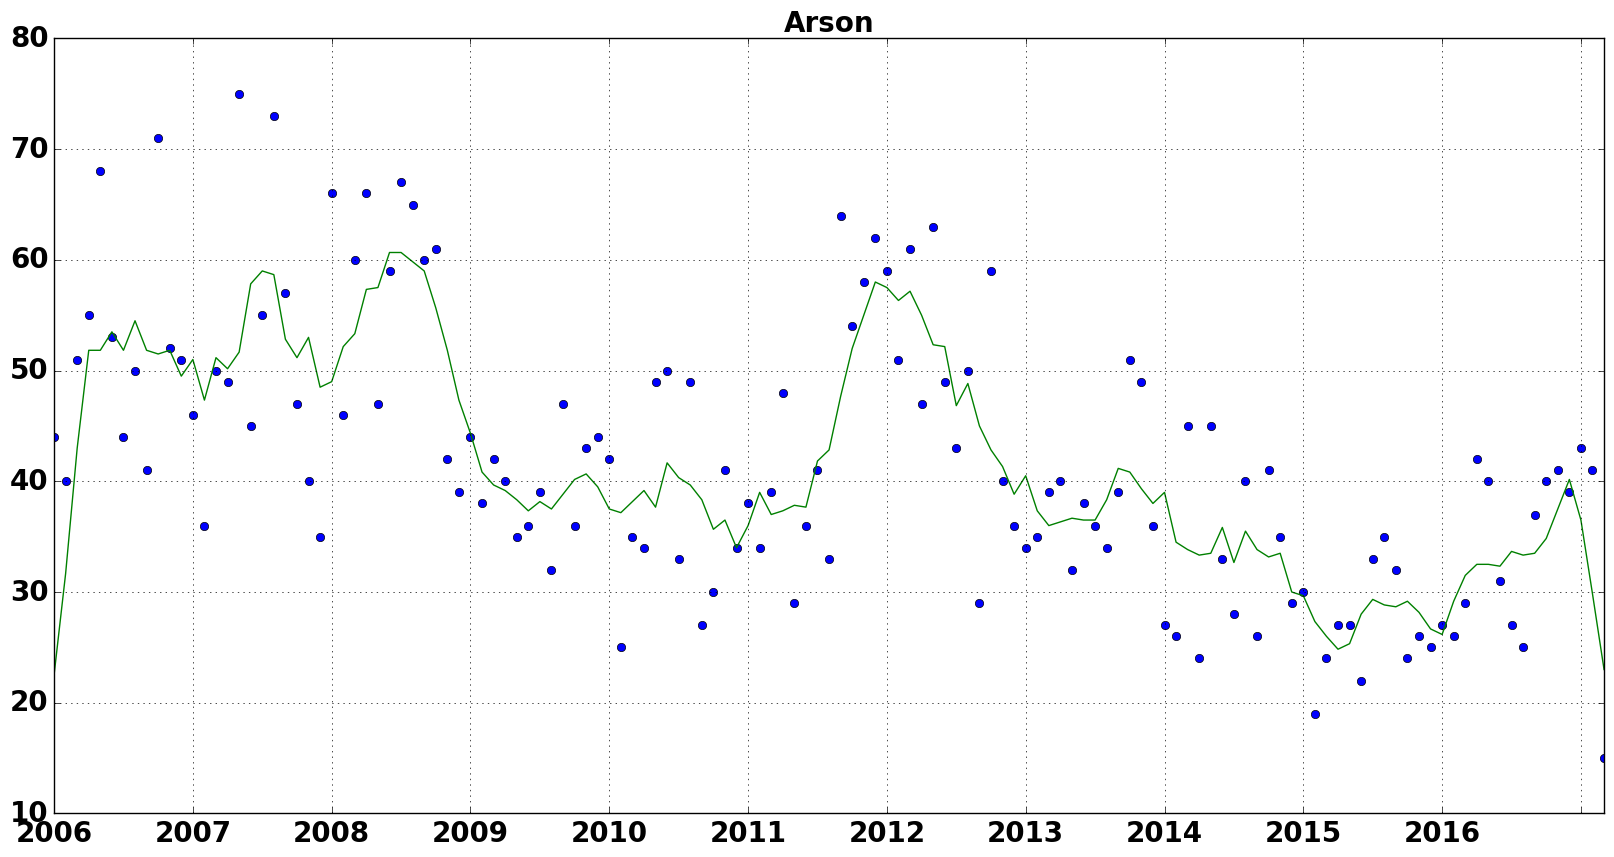

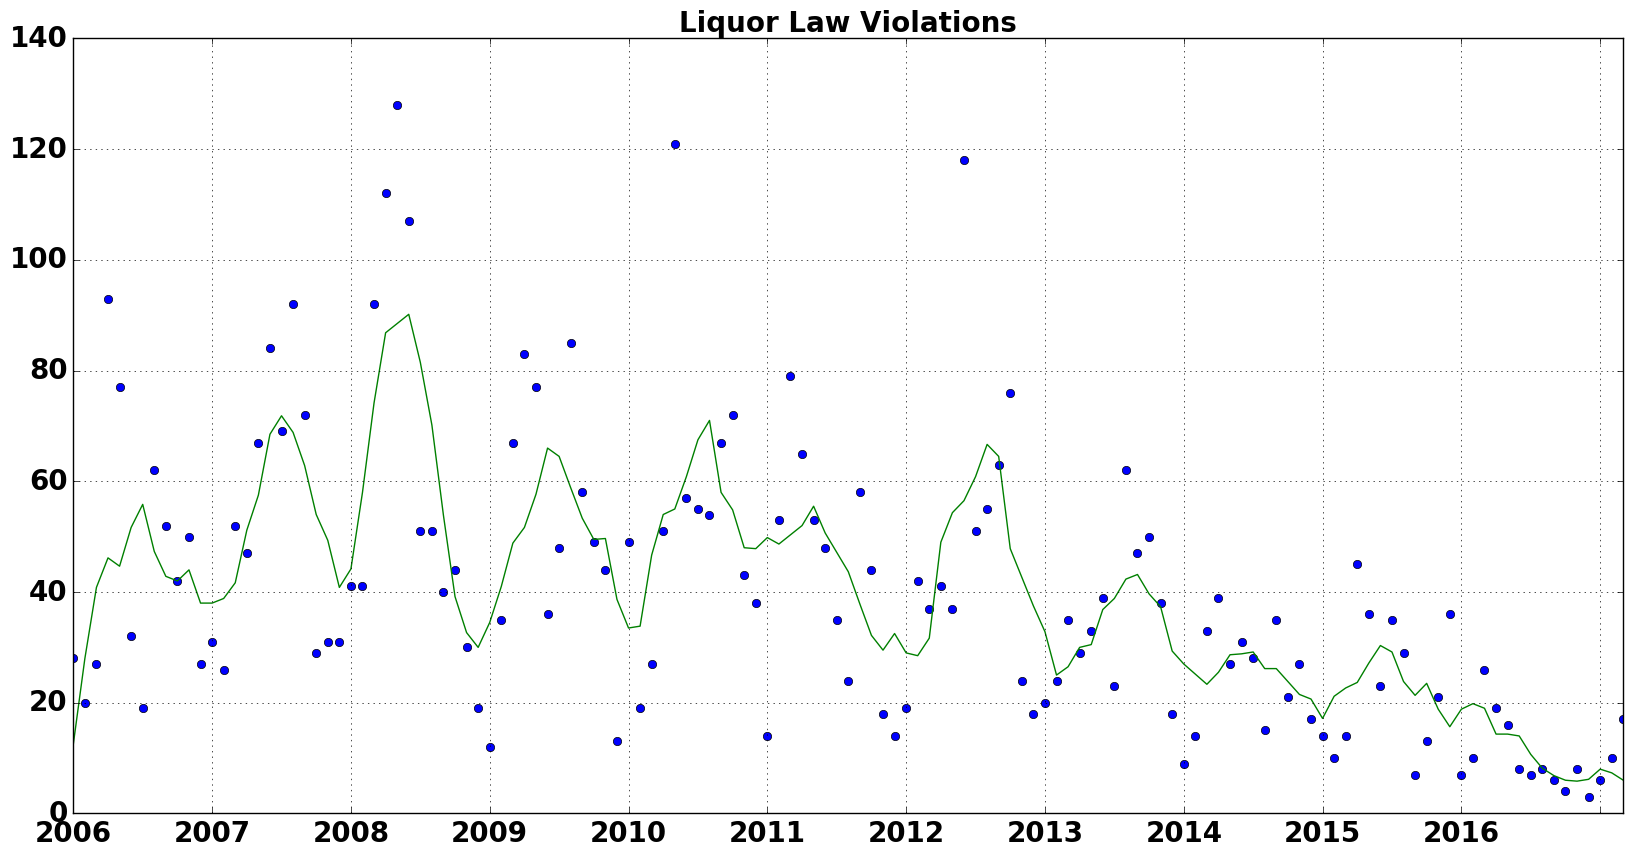

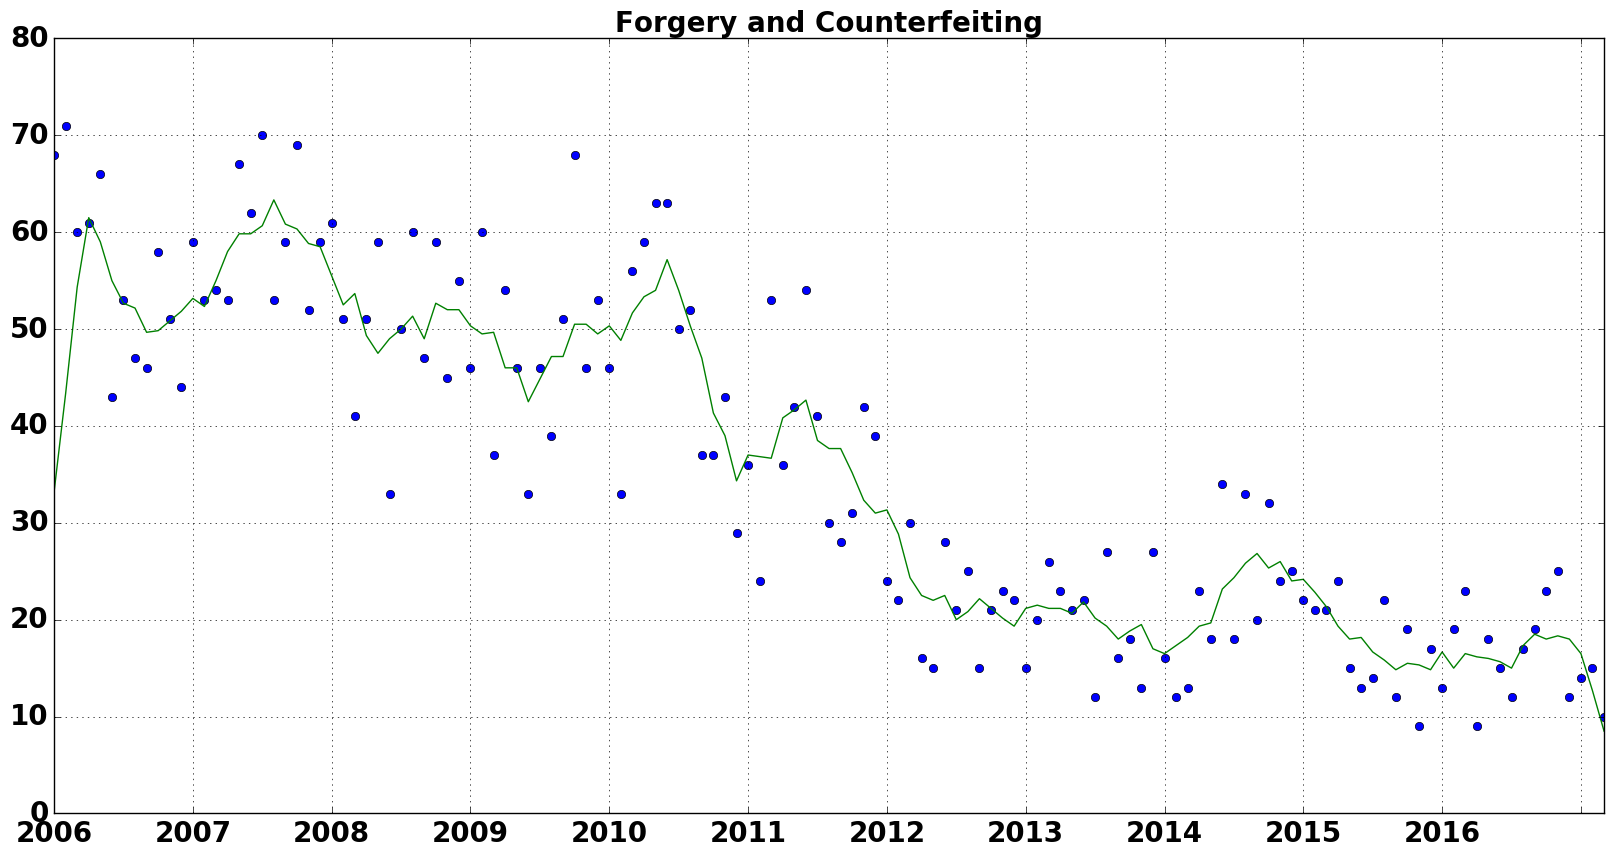

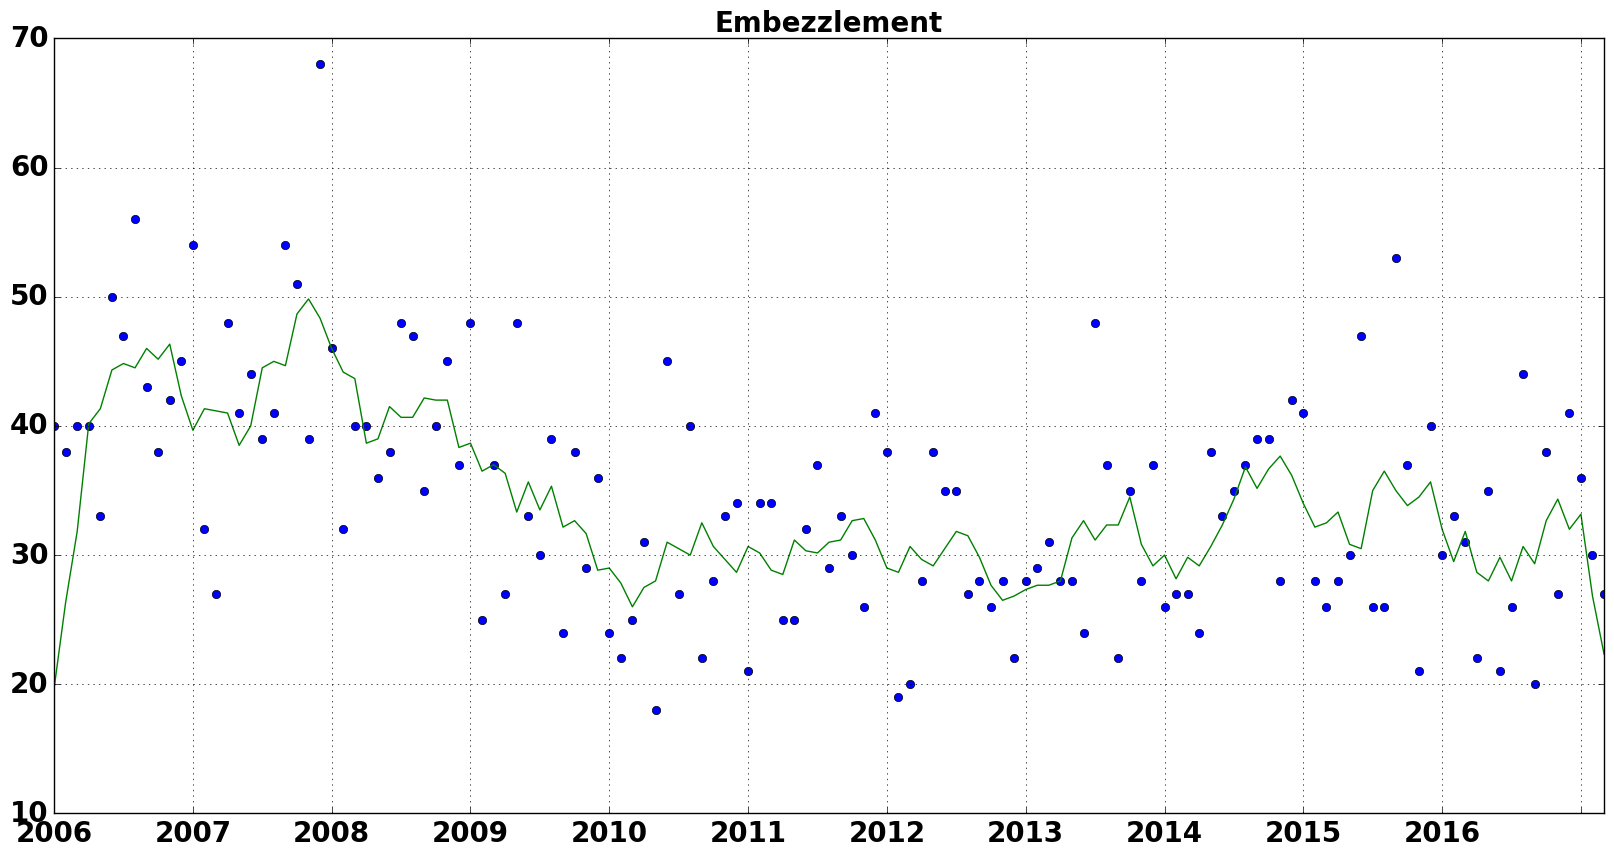

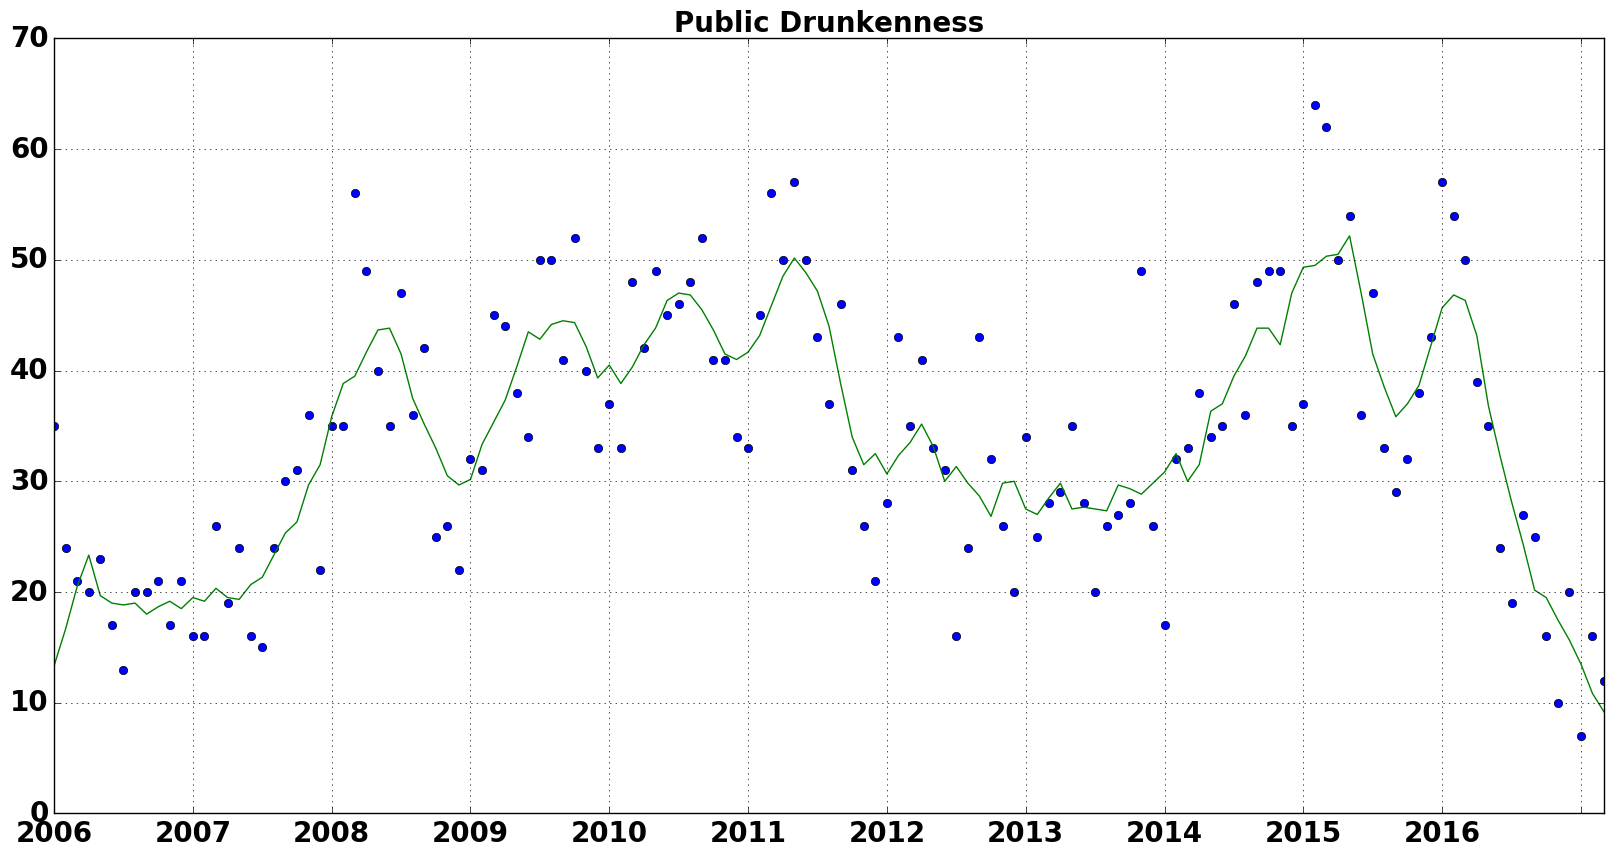

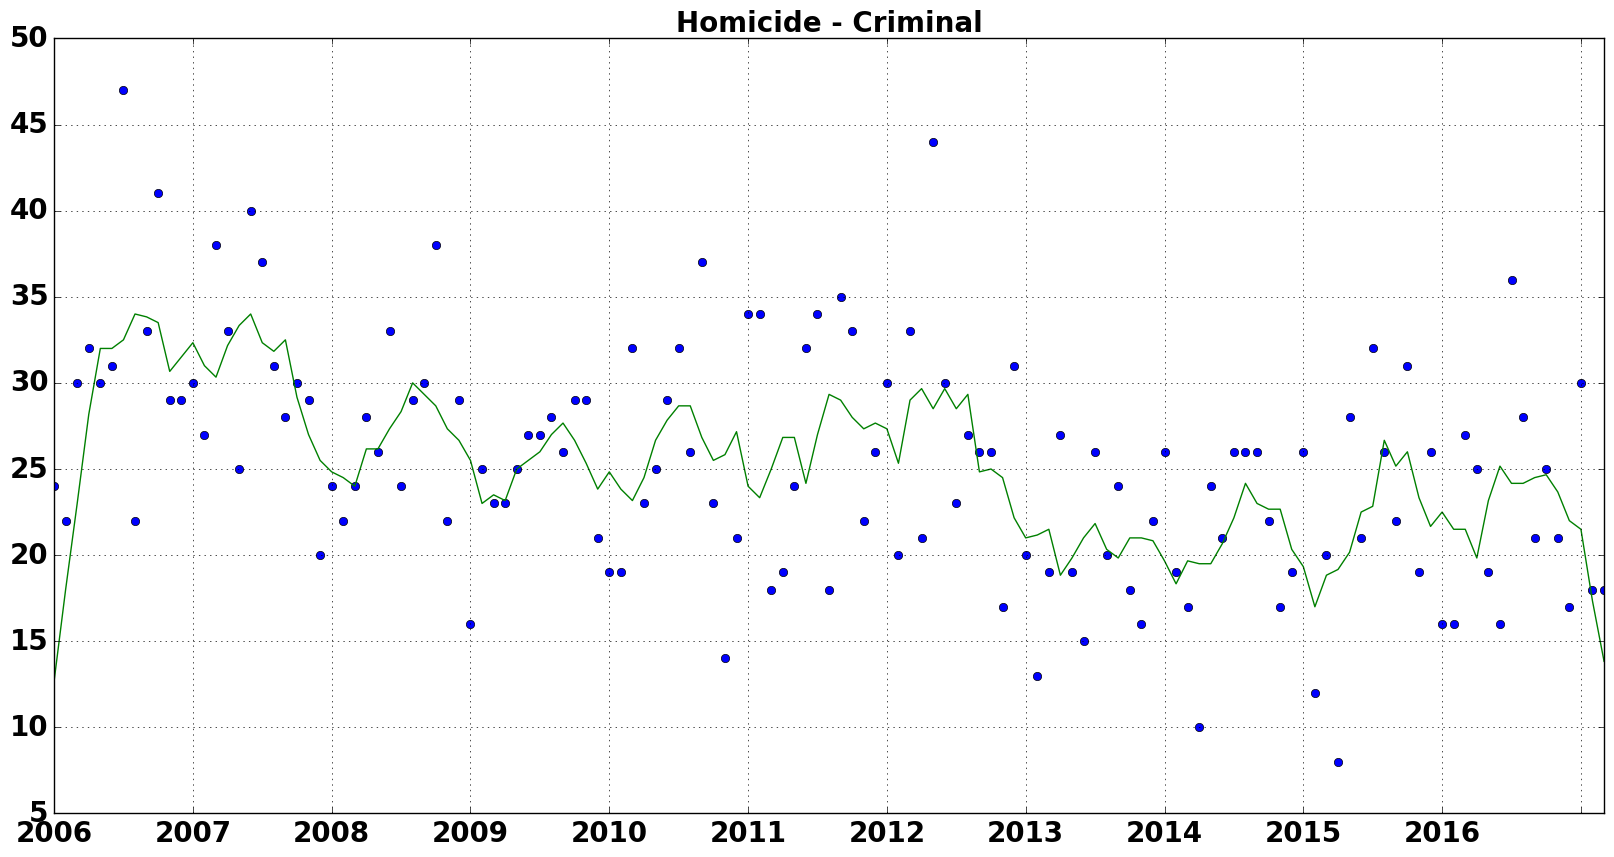

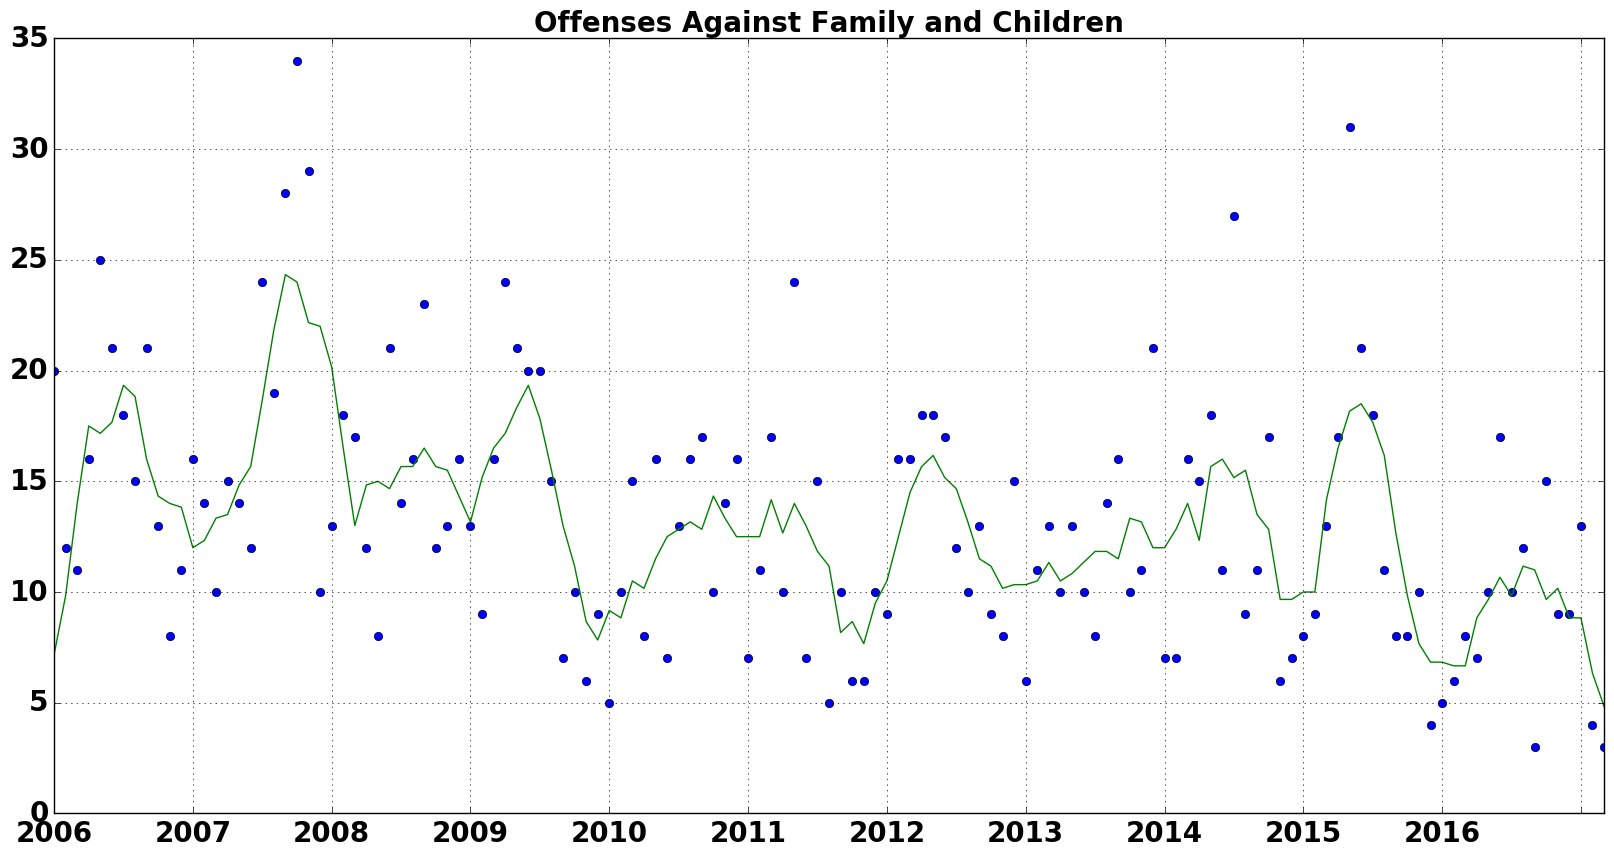

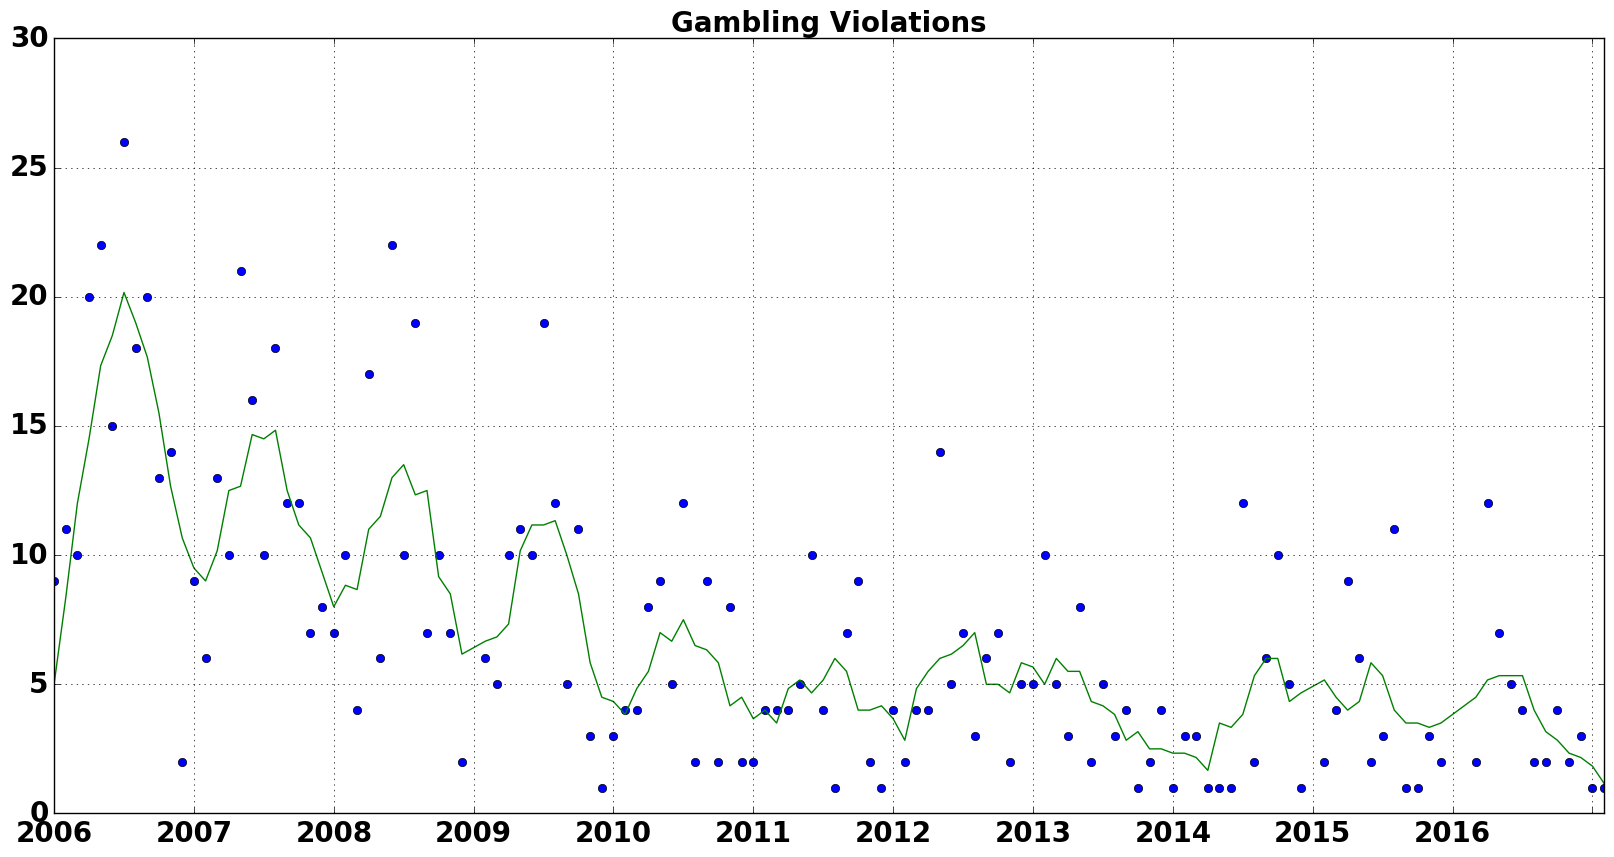

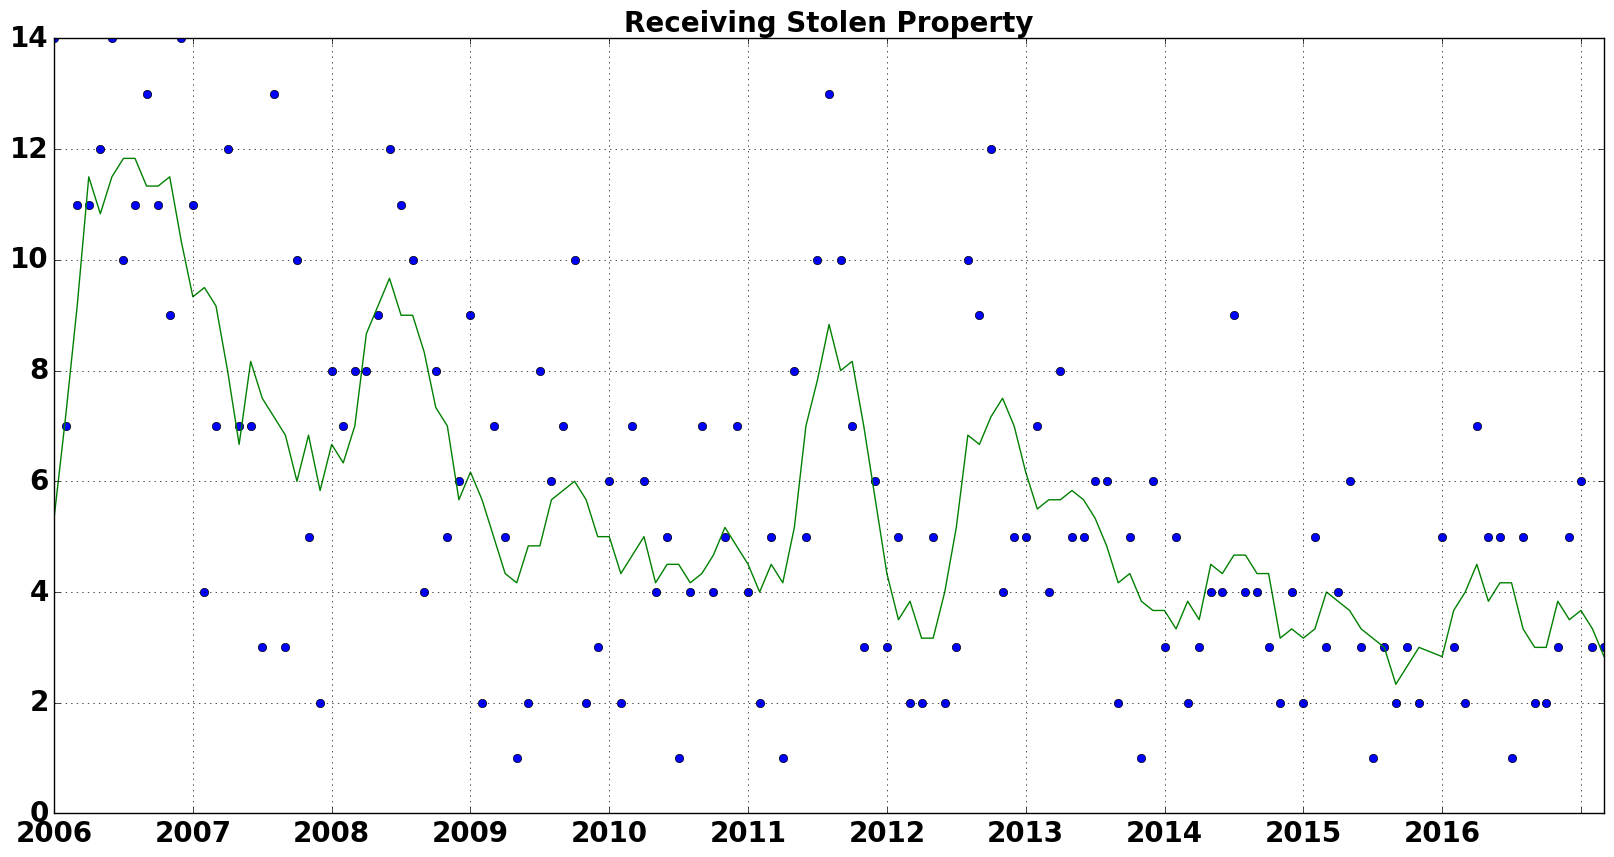

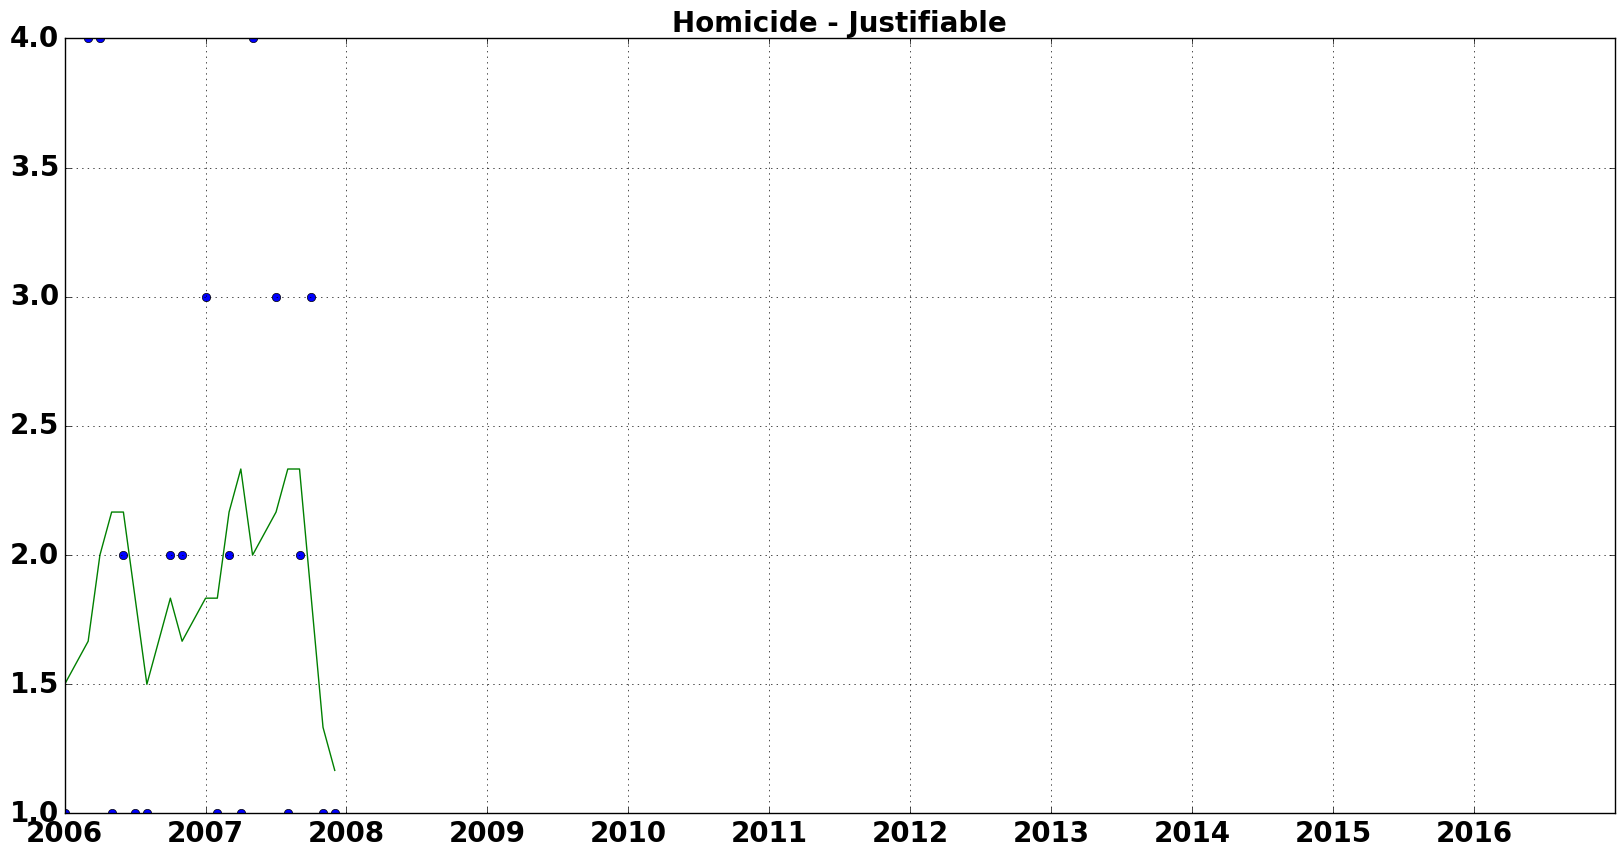

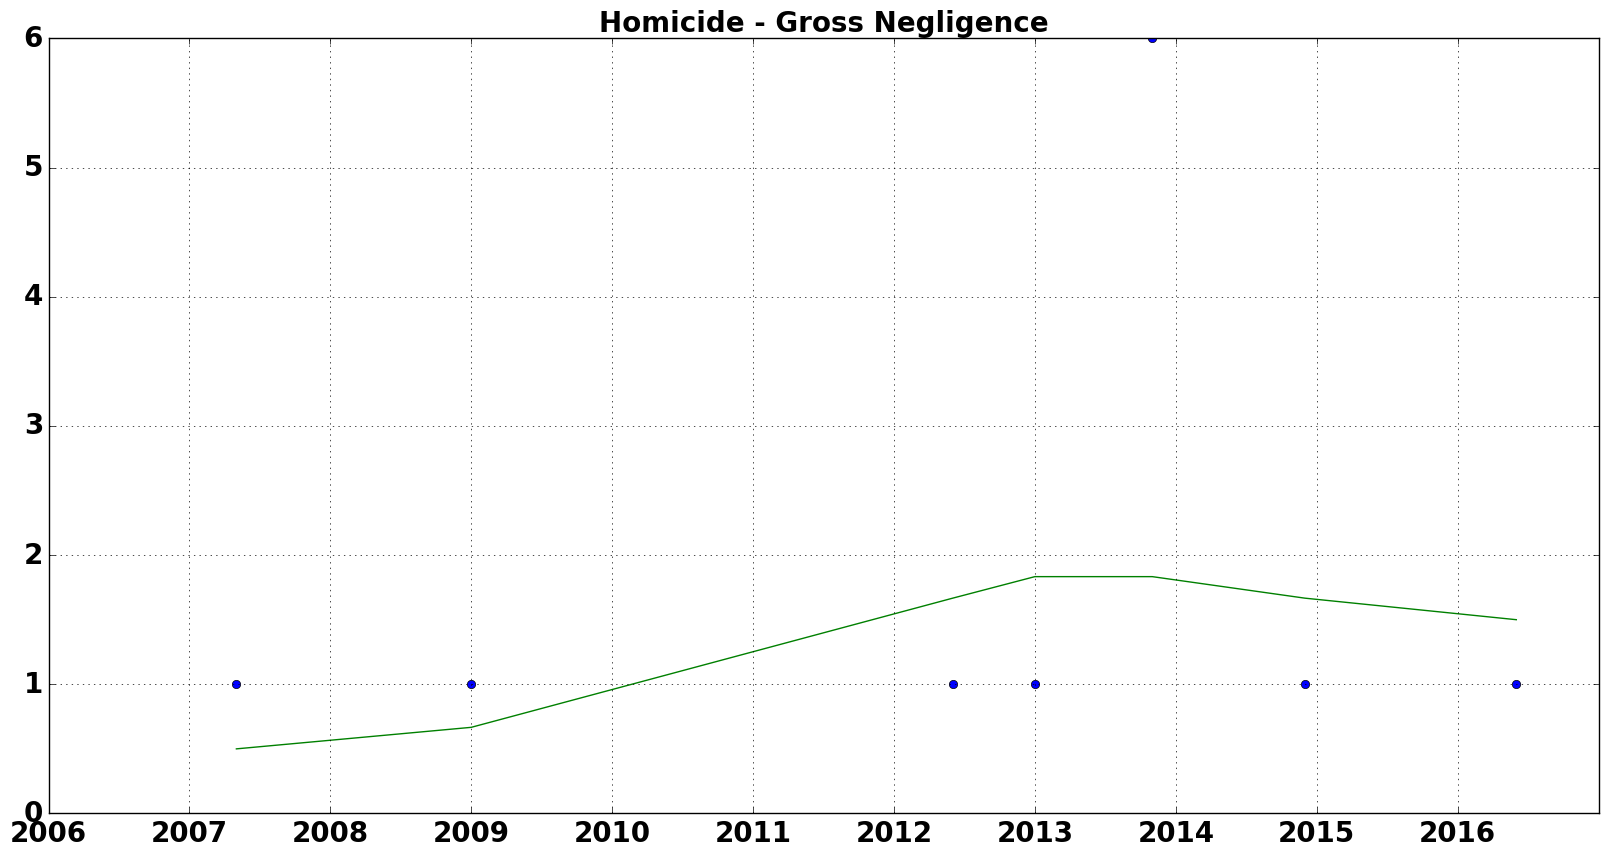

In [8]:
causes = DF.groupby('CAUSE')['COUNT'].count().sort_values(ascending=False).index

for i in causes:
    
    dummy_df = DF[DF['CAUSE']==i] 
    
    dummy_by_date = dummy_df.groupby('MTH_COUNT')['COUNT'].sum().reset_index()
    
    plt.figure(figsize=(20,10))
    
    plt.plot_date(dummy_by_date['MTH_COUNT'],dummy_by_date['COUNT'])
    plt.plot_date(dummy_by_date['MTH_COUNT'], movingaverage(dummy_by_date['COUNT'],6),'-')
    
    plt.title('%s' %i, **text_opts)
    plt.xticks(np.arange(xmin,xmax+1,12), np.arange((interval), dtype=int)+2006, **text_opts)
    plt.yticks(**text_opts)
    plt.grid()

Conclusion: For every crime there is a cause. There are few crime incidents like Theft of vehicle that are constanly taking place in all the time frames and seasons. This analysis will help us to monitor few channels that will help us in reducing the crime rate.
